# TMD 2024
### Lucas Poma
## Trabajo Practico Final

## Imports

In [ ]:
library(ggplot2)
library(rpart)
library(class)
library(MASS)
library(cluster)
install.packages("caret")
library(caret)
install.packages("randomForest")
library(randomForest)
install.packages("kernlab")
library(kernlab)
install.packages("gridExtra")
library(gridExtra)
install.packages("xgboost")
require(xgboost)
install.packages("e1071")
library(e1071)
install.packages("kernlab")
library(kernlab)
install.packages("tidyquant")
library(tidyquant)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’



## Funciones

### Estimadores Error

In [ ]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
  invisible(capture.output(model <- ksvm(as.matrix(x.train), as.factor(y), type=type,kernel=kernel,C=C,cross = cross)))
  return ( model@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
  num.feat<-dim(x.train)[2]
  tot.problems<-nlevels(y)*(nlevels(y)-1)/2

  invisible(capture.output(m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)))

  w<-rep(0.0,num.feat)
  for(i in 1:tot.problems) for(feat in 1:num.feat)
      w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
  rank.list<-sort(w,decreasing=FALSE,index=T)
  return(list(feats=rank.list$ix,imp=rank.list$x))
}

### Rankers

In [ ]:
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		    features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",list.feat,"\n")
	}

 	return(list.feat)

}

In [ ]:
backward.ranking <- function(x, y, method, verbosity = 0, ...) {

  max.feat <- dim(x)[2]    # num de features
  list.feat <- 1:max.feat  # inicializo
  keep.feat <- double(max.feat)  # orden de las vars

  # removemos la feature menos importante hasta que quede 1
  while(length(list.feat) > 1){

    class.error <- double(length(list.feat))

    # entreno el modelo y calculo el error sin esa variable
    for(i in 1:length(list.feat)){
      x.train <- as.matrix(x[, list.feat[-i]])
      class.error[i] <- do.call(method, c(list(x.train, y), list(...)))
    }

    # vemos cual es la que genera el menor error
    worst.feat <- which.min(class.error)

    # emovemos la feature para la prox iteracion
    keep.feat[length(list.feat)] <- list.feat[worst.feat]
    list.feat <- list.feat[-worst.feat]

    if(verbosity > 1) {
      cat("\nStep ", max.feat - length(list.feat), "\nRemoved Feature: ", worst.feat, "\n")
    }
  }

  # la ultima feature es la mas importante
  keep.feat[1] <- list.feat

  return(keep.feat)
}

In [ ]:
kruskal.ranking <- function(x, y, verbosity = 0) {

  max.feat <- dim(x)[2]  # num de features
  p.values <- double(max.feat)  # guardo p-values

  # calculamos los p-values con Kruskal Wallis
  for (i in 1:max.feat) {
    p.values[i] <- kruskal.test(x[, i], y)$p.value

    if (verbosity > 1) {
      cat("Feature", i, "- p-value:", p.values[i], "\n")
    }
  }

  # rankeamos las features segun el p-value
  list.feat <- order(p.values)

  if (verbosity > 1) {
    cat("\nFinal ranking of features based on Kruskal-Wallis test:\n")
    cat("Features ranked (by index):", list.feat, "\n")
  }

  return(list.feat)
}

In [ ]:
rfe.ranking <- function(x, y, method, verbosity = 0, ...) {

  max.feat <- dim(x)[2]  # num de features
  list.feat <- 1:max.feat  # lista de features
  rank.list <- double(max.feat)  # ranking de features

  # removemos 1 feature por iteracion
  for (i in 1:max.feat) {
    # entrenamos el modelo usando las features que nos quedan
    x.train <- as.matrix(x[, list.feat])

    # rankeamos las features segun el metodo
    ranking <- do.call(method, c(list(x.train, y), list(...)))

    # obtenemos la menos importante
    last <- ranking$feats[1]

    # guardamos la menos importante en la lista de rankings y la sacamos de las restantes
    rank.list[max.feat - i + 1] <- list.feat[last]
    list.feat <- list.feat[-last]

    if (verbosity > 1) {
      cat("Step", i, "- Removed feature:", last, "\n")
    }
  }

  if (verbosity > 1) {
    cat("\nFinal ranking of features using RFE:\n")
    cat("Features ranked (by index):", rank.list, "\n")
  }

  return(rank.list)
}

### Comparar Clusters

In [ ]:
# Step 2: Define a helper function to create and display confusion matrices with optimized matching
compare_clusters <- function(true_labels, predicted_clusters, title) {
    # Convert true labels to factors if they are not already
    true_labels <- as.factor(true_labels)

    # Create a confusion matrix
    confusion_matrix <- table(True = true_labels, Predicted = predicted_clusters)

    # Use matchClasses to find the optimal permutation of predicted clusters
    class.match <- matchClasses(as.matrix(confusion_matrix), method = "exact")

    # Reorder the confusion matrix using the optimal match
    optimized_confusion_matrix <- confusion_matrix[, class.match]

    # Calculate accuracy using the optimized confusion matrix
    accuracy <- sum(diag(optimized_confusion_matrix)) / sum(optimized_confusion_matrix)

    print(title)
    print(optimized_confusion_matrix)
    print("----------------------------------------------------")
}

### Metodos Cantidad Clusters

In [ ]:
# Generate n datasets with uniform distributions based on a PCA of the original
generate_reference_datasets <- function(original_dataset, n) {
    rows <- nrow(original_dataset)
    cols <- ncol(original_dataset)

    pca <- prcomp(original_dataset)

    ranges <- apply(pca$x, 2, range)
    reference_datasets <- vector("list", n)

    for (i in 1:n) {
        # Initialize a matrix to store a single reference dataset
        reference_dataset <- matrix(0, nrow = rows, ncol = min(rows, cols))

        # Populate each column with uniform values within the component ranges
        for (j in 1:min(rows, cols)) {
            reference_dataset[, j] <- runif(rows, ranges[1, j], ranges[2, j])
        }

        reference_datasets[[i]] <- reference_dataset
    }

    return(reference_datasets)
}

gap_statistic <- function(dataset, max_clusters, num_references) {
    gap <- numeric(max_clusters)
    sk <- numeric(max_clusters)

    # Generate B reference datasets
    reference_datasets <- generate_reference_datasets(dataset, num_references)

    # Iterate till K max clusters
    for (k in 2:max_clusters) {
        # Calculate within dispersion for the dataset
        Wk <- kmeans(dataset, centers = k)$tot.withinss

        # Calculate within dispersion for all references
        Wk_references <- sapply(reference_datasets, function(ref) kmeans(ref, centers = k)$tot.withinss)

        # Compute the estimated Gap statistic for k clusters. (1/B) is the same as the mean
        gap[k] <- mean(log(Wk_references)) - log(Wk)

        # Compute the standard deviation for Wk references
        sd_k <- sqrt(mean((log(Wk_references) - mean(log(Wk_references)))^2))
        sk[k] <- sd_k * sqrt(1 + 1 / num_references)
    }

    # Compute optimal_clusters which is the smallest k such that Gap(k) >= Gap(K+1) - s_k+1
    optimal_clusters <- 2
    while (optimal_clusters < max_clusters &&
           gap[optimal_clusters] < gap[optimal_clusters + 1] - sk[optimal_clusters + 1]) {
        optimal_clusters <- optimal_clusters + 1
    }

    return(optimal_clusters)
}

In [ ]:
stability_score <- function(n, ind1,  cc1, ind2, cc2){
  #pongo los clusters de nuevo en longitud n - quedan 0 los puntos fuera del sample.
  #Sumo 5 a las etiquetas para que valga el truco que la raiz de multiplicar las "clases" es un numero entero solo cuando tienen el
  v1 <- v2 <- rep(0,n)
  v1[ind1] <- cc1+5
  v2[ind2] <- cc2+5
  #creo una matriz m con 1 donde los dos puntos estan en el mismo cluster, -1 en distinto cluster y 0 si alguno no esta, para cada
  # clustering
  a <- sqrt(v1%*%t(v1))
  m1<- a / -a + 2*(a==round(a))
  m1[is.nan(m1)] <- 0
  a <- sqrt(v2%*%t(v2))
  m2 <- a / -a + 2*(a==round(a))
  m2[is.nan(m2)] <- 0
  #calculo el score, los pares de puntos que estan en la misma situacion en los dos clustering dividido el total de pares validos.
  validos <- sum(v1*v2>0)
  score <- sum((m1*m2)[upper.tri(m1)]>0)/(validos*(validos-1)/2)
  return(score)
}

stability_method <- function(dataset, max_clusters, nRep) {
    n <- nrow(dataset)
    size <- 0.9
    stability_scores <- vector("list", max_clusters)
    stability_means <- numeric(max_clusters)

    # Subsampling
    subsamples <- lapply(1:nRep, function(i) sample(n, floor(size * n)))

    # Iterate till K max clusters
    for (k in 2:max_clusters) {
        # k-means on each subsample
        cluster_labels <- lapply(subsamples, function(indices) kmeans(dataset[indices, ], centers = k)$cluster)

        # Compare with stability_score
        scores <- c()
        for (i in 1:(nRep - 1)) {
            for (j in (i + 1):nRep) {
                score <- stability_score(n, subsamples[[i]], subsamples[[j]], cluster_labels[[i]], cluster_labels[[j]])
                if (!is.nan(score)) {  # Exclude NaN values
                    scores <- c(scores, score)
                }
            }
        }

        # Store scores and calculate mean only if scores exist
        stability_scores[[k]] <- scores
        stability_means[k] <- if (length(scores) > 0) mean(scores) else 0
    }

    return(list(stability = stability_scores, stability.means = stability_means))
}

## Analisis de SPY 2023Q3-2024Q3

Para este trabajo, generé un dataset utilizando un script en Python que descarga los datos históricos (con YahooFinance) de las acciones que componen el índice más reconocido de Estados Unidos, el Standard & Poor's 500 (S&P 500), que agrupa a las 500 empresas con mayor capitalización bursátil del país. En este dataset, las columnas representan la variación porcentual de algunos indicadores financieros presentados en los balances (comparando los periodos fiscales de 2023Q3 a 2024Q3), con excepción de la primera columna, que contiene los nombres con los que cotizan las empresas, y la última, que refleja la variación del precio de las acciones (con un desfase de un mes respecto al Q3 de cada año, debido a que los balances pueden tardar hasta 30 días en ser publicados). Cada fila del dataset corresponde a una acción.

Alteramos la última columna para simplificar y generar clases. Para ello, comparamos el desempeño de cada acción con el índice en el mismo periodo. Asignamos un valor de -1 si tuvo un rendimiento inferior al del índice y un valor de 1 si lo superó.

El objetivo principal de este trabajo es analizar la validez de la teoría de los mercados eficientes, que sostiene que toda la información pública se refleja de manera inmediata en el precio de las acciones, y determinar si esta información proviene en gran medida de los resultados financieros que genera cada empresa.

### Cleaning

In [ ]:
stocksCSV <- read.csv('/content/spyFundamentals2023_2024.csv')

In [ ]:
head(stocksCSV)
summary(stocksCSV)

,Ticker,Market.Capitalization,Total.Debt,Cash.and.Cash.Equivalents,Enterprise.Value,EBITDA,Total.Revenue,Gross.Profit,Operating.Revenue,Operating.Income,Net.Income,Free.Cash.Flow,Repurchase.Of.Capital.Stock,Repayment.Of.Debt,Issuance.Of.Debt,Issuance.Of.Capital.Stock,Capital.Expenditure,Stock.Price.Change
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MMM,84.4756274,-0.005932958,62.32558,59.655980,-177.82383,-4.522481,-5.287724,-4.522481,-324.278023,-221.083607,31.832379,-97.745902,161.74724,283400.00000,NA,-7.661521,78.15653
2,AOS,35.8704715,-57.699645680,-13.11350,34.317586,165.74194,2.634593,11.672684,2.634593,14.984060,136.147645,86.141389,-24.039653,NA,NA,NA,3.271693,10.50576
3,ABT,18.2467546,-11.785956198,-30.21656,17.937660,-13.08219,-8.118571,-9.697687,-8.118571,-22.530495,-17.452762,-35.174270,-67.667984,231.73971,-71.42857,NA,23.916714,25.52041
4,ABBV,35.4792682,-6.141834332,39.26747,26.758389,-28.96500,-6.435388,-16.577264,-6.435388,-29.585472,-58.913484,-9.015177,32.616005,-71.25338,-100.00000,NA,11.798561,47.20267
5,ACN,15.2902043,30.851207069,-44.67163,18.517907,5.67382,1.223986,2.077552,1.223986,8.921316,5.722575,-4.241595,4.485564,NA,1499.03300,-5.525262,-2.208182,20.30791
6,ADBE,-0.4374027,-11.936110512,68.57885,-1.902102,11.58257,10.240827,10.452691,10.240827,9.052148,14.129521,-6.138453,-32.824427,NA,NA,12.949640,-18.552036,-7.64034


    Ticker          Market.Capitalization   Total.Debt      
 Length:503         Min.   :-56.20        Min.   : -57.700  
 Class :character   1st Qu.: 11.81        1st Qu.:  -3.661  
 Mode  :character   Median : 29.10        Median :   1.067  
                    Mean   : 30.44        Mean   :  25.546  
                    3rd Qu.: 48.12        3rd Qu.:   9.597  
                    Max.   :224.46        Max.   :7164.655  
                    NA's   :9             NA's   :10        
 Cash.and.Cash.Equivalents Enterprise.Value      EBITDA        
 Min.   : -94.45           Min.   :-54.340   Min.   :-820.977  
 1st Qu.: -12.78           1st Qu.:  9.021   1st Qu.: -11.041  
 Median :   7.68           Median : 21.216   Median :   7.019  
 Mean   :  52.95           Mean   : 26.787   Mean   :  10.585  
 3rd Qu.:  40.69           3rd Qu.: 36.411   3rd Qu.:  21.313  
 Max.   :5403.43           Max.   :927.591   Max.   : 850.493  
 NA's   :5                 NA's   :13        NA's   :52        


Observamos que el dataset contiene varios valores faltantes (NA), muchas gracias Yahoo Finance. Algunos de estos valores ausentes tienen sentido, mientras que otros no. En particular, los relacionados con el dinero que genera la empresa y su valor en bolsa son incorrectos, ya que no deberían carecer de datos. Por lo tanto, procedemos a eliminar esas filas del dataset.

In [ ]:
stocksCSV_clean <- subset(stocksCSV,
                          !is.na(Gross.Profit) &
                          !is.na(Stock.Price.Change) &
                          !is.na(Enterprise.Value) &
                          !is.na(Market.Capitalization))
summary(stocksCSV_clean)

    Ticker          Market.Capitalization   Total.Debt      
 Length:437         Min.   :-56.201       Min.   : -57.700  
 Class :character   1st Qu.:  8.994       1st Qu.:  -4.014  
 Mode  :character   Median : 26.529       Median :   0.999  
                    Mean   : 29.169       Mean   :  23.194  
                    3rd Qu.: 46.311       3rd Qu.:   9.597  
                    Max.   :224.465       Max.   :7164.655  
                                                            
 Cash.and.Cash.Equivalents Enterprise.Value      EBITDA        
 Min.   : -94.448          Min.   :-37.893   Min.   :-820.977  
 1st Qu.: -13.488          1st Qu.:  8.145   1st Qu.: -11.768  
 Median :   8.825          Median : 20.914   Median :   6.823  
 Mean   :  57.016          Mean   : 24.039   Mean   :  11.123  
 3rd Qu.:  44.817          3rd Qu.: 36.012   3rd Qu.:  21.285  
 Max.   :5403.431          Max.   :177.049   Max.   : 850.493  
                                                               


Por otro lado, los valores faltantes que quedan tras esta limpieza sí tienen sentido, ya que corresponden a aspectos como emisiones de la empresa, pagos de deuda o inversiones. En consecuencia, imputamos estos valores estableciéndolos en 0.

In [ ]:
stocksCSV_clean[is.na(stocksCSV_clean)] <- 0
summary(stocksCSV_clean)

    Ticker          Market.Capitalization   Total.Debt      
 Length:437         Min.   :-56.201       Min.   : -57.700  
 Class :character   1st Qu.:  8.994       1st Qu.:  -4.014  
 Mode  :character   Median : 26.529       Median :   0.999  
                    Mean   : 29.169       Mean   :  23.194  
                    3rd Qu.: 46.311       3rd Qu.:   9.597  
                    Max.   :224.465       Max.   :7164.655  
 Cash.and.Cash.Equivalents Enterprise.Value      EBITDA        
 Min.   : -94.448          Min.   :-37.893   Min.   :-820.977  
 1st Qu.: -13.488          1st Qu.:  8.145   1st Qu.: -11.768  
 Median :   8.825          Median : 20.914   Median :   6.823  
 Mean   :  57.016          Mean   : 24.039   Mean   :  11.123  
 3rd Qu.:  44.817          3rd Qu.: 36.012   3rd Qu.:  21.285  
 Max.   :5403.431          Max.   :177.049   Max.   : 850.493  
 Total.Revenue      Gross.Profit      Operating.Revenue Operating.Income  
 Min.   :-64.217   Min.   :-496.398   Min.   :-63.

Procedemos a generar las clases. Para ello, calculamos la variación del índice durante el mismo período y recalculamos la última columna para cada entrada en función de esta comparación.

In [ ]:
start_date <- "2023-10-31"
end_date <- "2024-10-31"

spy_data <- tq_get("^GSPC", from = start_date, to = end_date)

spy_total_return <- ((last(spy_data$adjusted, na.rm = TRUE) / first(spy_data$adjusted, na.rm = TRUE)) - 1) * 100
cat("Total Return between", start_date, "and", end_date, "is:", round(spy_total_return, 2), "%\n")

Total Return between 2023-10-31 and 2024-10-31 is: 38.63 %


In [ ]:
stocksCSV_clean$Stock.Price.Change <- ifelse(
  stocksCSV_clean$Stock.Price.Change > spy_total_return,  # Compare with index return
  1,  # Overperforms
  -1  # Underperforms
)

stocksCSV_clean$Stock.Price.Change <- as.factor(stocksCSV_clean$Stock.Price.Change)
head(stocksCSV_clean)
summary(stocksCSV_clean)

,Ticker,Market.Capitalization,Total.Debt,Cash.and.Cash.Equivalents,Enterprise.Value,EBITDA,Total.Revenue,Gross.Profit,Operating.Revenue,Operating.Income,Net.Income,Free.Cash.Flow,Repurchase.Of.Capital.Stock,Repayment.Of.Debt,Issuance.Of.Debt,Issuance.Of.Capital.Stock,Capital.Expenditure,Stock.Price.Change
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,MMM,84.4756274,-0.005932958,62.32558,59.655980,-177.82383,-4.522481,-5.287724,-4.522481,-324.278023,-221.083607,31.832379,-97.745902,161.74724,283400.00000,0.000000,-7.661521,1
2,AOS,35.8704715,-57.699645680,-13.11350,34.317586,165.74194,2.634593,11.672684,2.634593,14.984060,136.147645,86.141389,-24.039653,0.00000,0.00000,0.000000,3.271693,-1
3,ABT,18.2467546,-11.785956198,-30.21656,17.937660,-13.08219,-8.118571,-9.697687,-8.118571,-22.530495,-17.452762,-35.174270,-67.667984,231.73971,-71.42857,0.000000,23.916714,-1
4,ABBV,35.4792682,-6.141834332,39.26747,26.758389,-28.96500,-6.435388,-16.577264,-6.435388,-29.585472,-58.913484,-9.015177,32.616005,-71.25338,-100.00000,0.000000,11.798561,1
5,ACN,15.2902043,30.851207069,-44.67163,18.517907,5.67382,1.223986,2.077552,1.223986,8.921316,5.722575,-4.241595,4.485564,0.00000,1499.03300,-5.525262,-2.208182,-1
6,ADBE,-0.4374027,-11.936110512,68.57885,-1.902102,11.58257,10.240827,10.452691,10.240827,9.052148,14.129521,-6.138453,-32.824427,0.00000,0.00000,12.949640,-18.552036,-1


    Ticker          Market.Capitalization   Total.Debt      
 Length:437         Min.   :-56.201       Min.   : -57.700  
 Class :character   1st Qu.:  8.994       1st Qu.:  -4.014  
 Mode  :character   Median : 26.529       Median :   0.999  
                    Mean   : 29.169       Mean   :  23.194  
                    3rd Qu.: 46.311       3rd Qu.:   9.597  
                    Max.   :224.465       Max.   :7164.655  
 Cash.and.Cash.Equivalents Enterprise.Value      EBITDA        
 Min.   : -94.448          Min.   :-37.893   Min.   :-820.977  
 1st Qu.: -13.488          1st Qu.:  8.145   1st Qu.: -11.768  
 Median :   8.825          Median : 20.914   Median :   6.823  
 Mean   :  57.016          Mean   : 24.039   Mean   :  11.123  
 3rd Qu.:  44.817          3rd Qu.: 36.012   3rd Qu.:  21.285  
 Max.   :5403.431          Max.   :177.049   Max.   : 850.493  
 Total.Revenue      Gross.Profit      Operating.Revenue Operating.Income  
 Min.   :-64.217   Min.   :-496.398   Min.   :-63.

Renombramos algunas columnas para que sean más legibles en los gráficos y, a continuación, realizamos un análisis de componentes principales (PCA).

In [ ]:
stocks.tickers <- stocksCSV_clean$Ticker
stocks.x <- stocksCSV_clean[, !(colnames(stocksCSV_clean) %in% c("Stock.Price.Change", "Ticker"))]
stocks.y <- stocksCSV_clean$Stock.Price.Change
colnames(stocks.x) <- c("MC", "TD", "CCE", "EV", "EBITDA",
                        "TR", "GP", "OR", "OI", "NI",
                        "FCF", "ROC", "ROD", "IOD", "ICS", "CE")
variable_names <- colnames(stocks.x)

In [ ]:
rownames(stocks.x) <- NULL
rownames(stocks.y) <- NULL
rownames(stocks.tickers) <- NULL

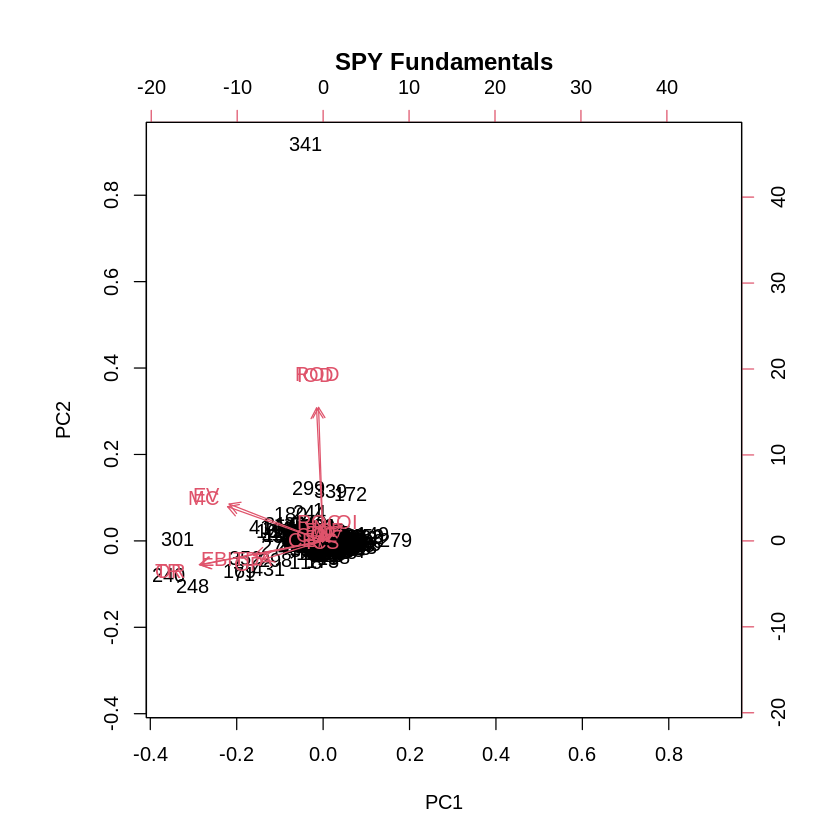

In [ ]:
stocks.pca<-prcomp(stocks.x, scale = T)
biplot(stocks.pca, main= "SPY Fundamentals")

Creo que no hace falta decir que la entrada 341 es un outlier

In [ ]:
stocks.x <- stocks.x[-341, ]
stocks.y <- stocks.y[-341]
stocks.tickers <- stocks.tickers[-341]

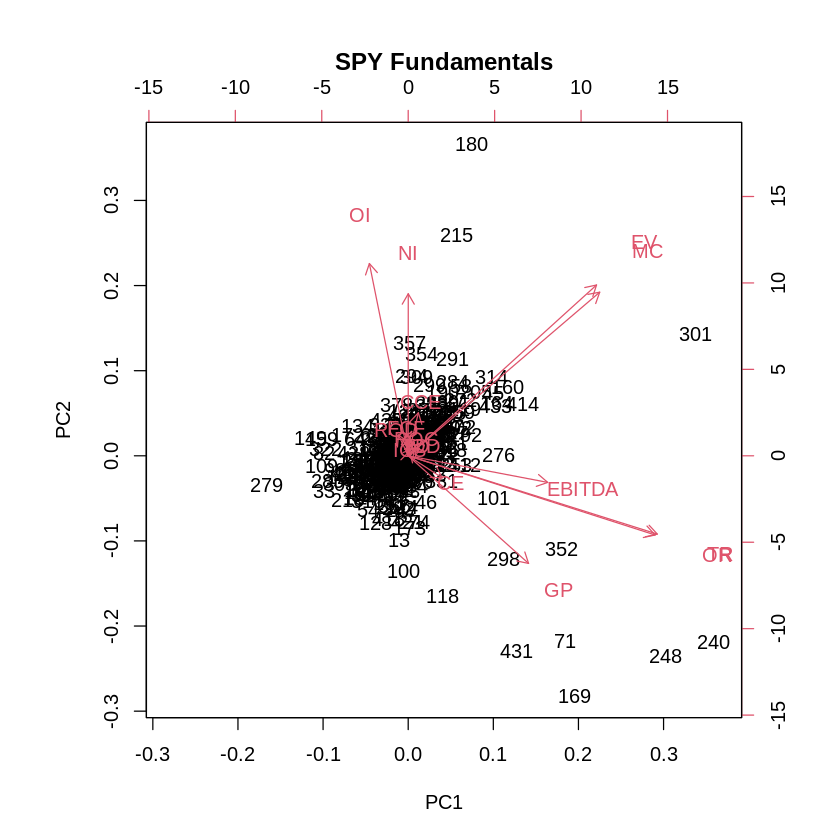

In [ ]:
stocks.pca<-prcomp(stocks.x, scale = T)
biplot(stocks.pca, main= "SPY Fundamentals")

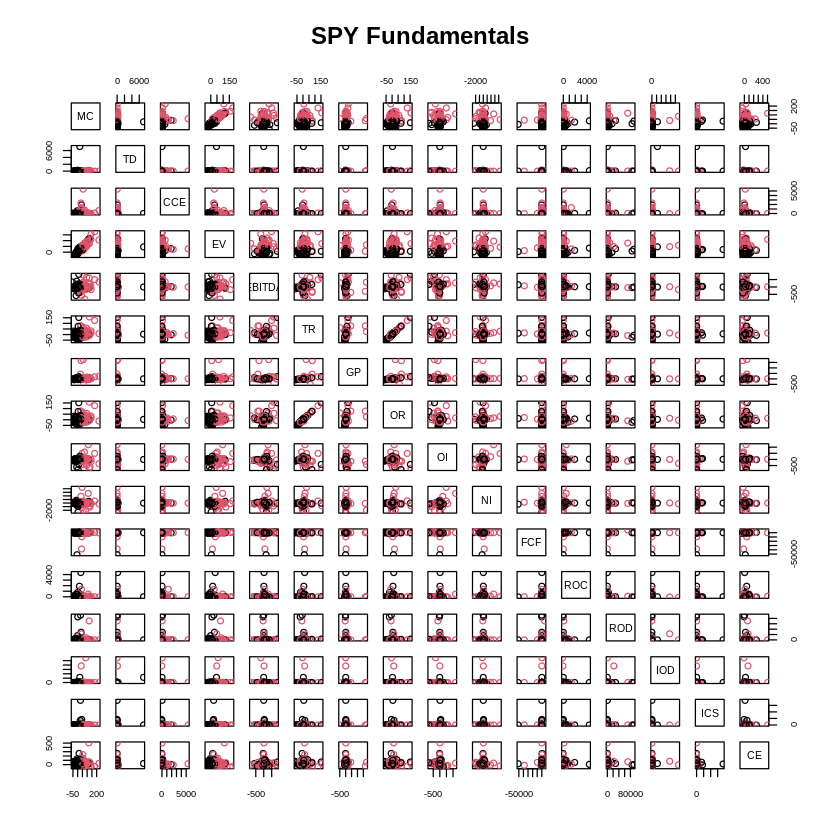

In [ ]:
plot(stocks.x, col=stocks.y, main="SPY Fundamentals", cex.axis=0.7, cex.main=1.2)

Dificil de ver en detalle, pero se observa una clara correlación entre Total Revenue y Operating Revenue, lo cual tiene sentido debido a que la segunda deriva directo de la primera. Asimismo, se identifica una correlación evidente entre Market Cap y Enterprise Value, ya que esta última se calcula a partir de la primera, ajustada por la deuda. Además, ciertas columnas muestran cierta separación de los datos.

In [ ]:
stocks.forward.rf <- forward.ranking(stocks.x, stocks.y, "rf.est")
stocks.forward.lda <- forward.ranking(stocks.x, stocks.y, "lda.est")
stocks.forward.svm <- forward.ranking(stocks.x, stocks.y, method="svm.est")

In [ ]:
stocks.forward.rf.names <- variable_names[stocks.forward.rf]
stocks.forward.lda.names <- variable_names[stocks.forward.lda]
stocks.forward.svm.names <- variable_names[stocks.forward.svm]

cat("\n > Forward ranking RF (Variable Names) \n")
print(stocks.forward.rf.names)

cat("\n > Forward ranking LDA (Variable Names) \n")
print(stocks.forward.lda.names)

cat("\n > Forward ranking SVM (Variable Names) \n")
print(stocks.forward.svm.names)


 > Forward ranking RF (Variable Names) 
 [1] "MC"     "FCF"    "OI"     "CE"     "CCE"    "ROC"    "NI"     "TD"    
 [9] "ROD"    "EV"     "ICS"    "GP"     "TR"     "IOD"    "EBITDA" "OR"    

 > Forward ranking LDA (Variable Names) 
 [1] "MC"     "EV"     "NI"     "GP"     "ICS"    "ROD"    "CCE"    "OI"    
 [9] "EBITDA" "TR"     "CE"     "IOD"    "FCF"    "TD"     "ROC"    "OR"    

 > Forward ranking SVM (Variable Names) 
 [1] "MC"     "OI"     "CE"     "EBITDA" "GP"     "TD"     "NI"     "OR"    
 [9] "TR"     "ICS"    "ROD"    "EV"     "IOD"    "CCE"    "ROC"    "FCF"   


Exactamente en este punto fue cuando me di cuenta de que MC (Market Cap) era un falso predictor. Esto se debe a que se calcula directamente a partir del precio de la acción multiplicado por la cantidad de acciones en circulación, lo que lo hace completamente correlacionado con la variable que estamos intentando predecir. En consecuencia, EV (Enterprise Value) también resulta ser un falso predictor, ya que su cálculo depende directamente de MC.

Se me pasó por alto porque estaba sesgado hacia el uso de algunas métricas habituales que incluyen estos dos indicadores. Procedemos a quitarlos de nuestro análisis y volvemos a empezar.

In [ ]:
stocks.tickers <- stocksCSV_clean$Ticker
stocks.x <- stocksCSV_clean[, !(colnames(stocksCSV_clean) %in% c("Stock.Price.Change", "Ticker", "Market.Capitalization", "Enterprise.Value"))]
stocks.y <- stocksCSV_clean$Stock.Price.Change
colnames(stocks.x) <- c("TD", "CCE", "EBITDA",
                        "TR", "GP", "OR", "OI", "NI",
                        "FCF", "ROC", "ROD", "IOD", "ICS", "CE")
variable_names <- colnames(stocks.x)

In [ ]:
rownames(stocks.x) <- NULL
rownames(stocks.y) <- NULL
rownames(stocks.tickers) <- NULL

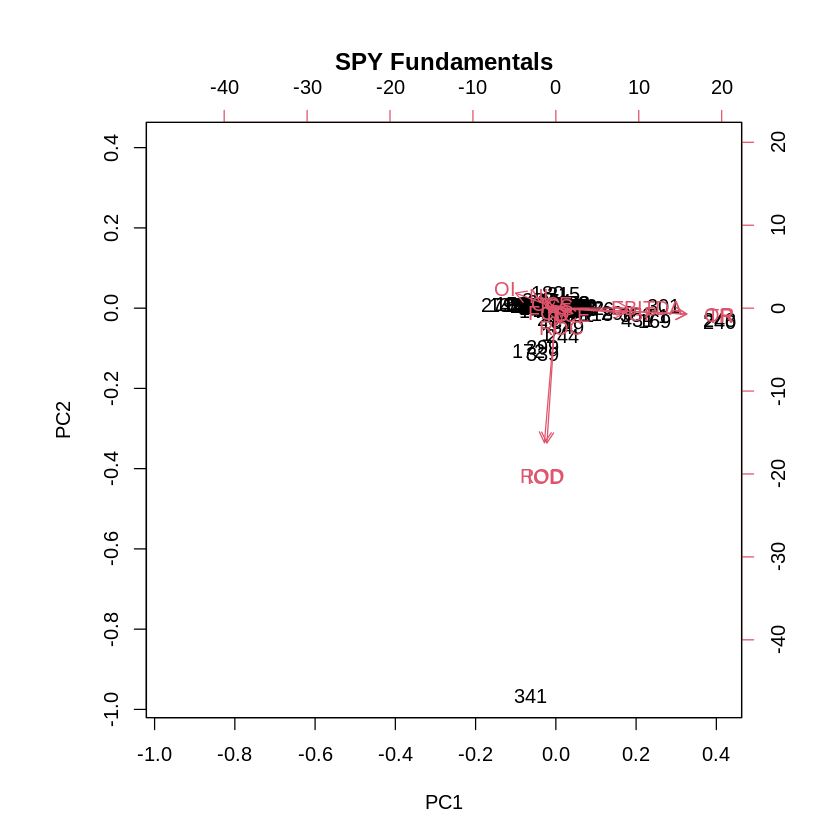

In [ ]:
stocks.pca<-prcomp(stocks.x, scale = T)
biplot(stocks.pca, main= "SPY Fundamentals")

La entrada 341 sigue igual de loca

In [ ]:
stocks.x <- stocks.x[-341, ]
stocks.y <- stocks.y[-341]
stocks.tickers <- stocks.tickers[-341]

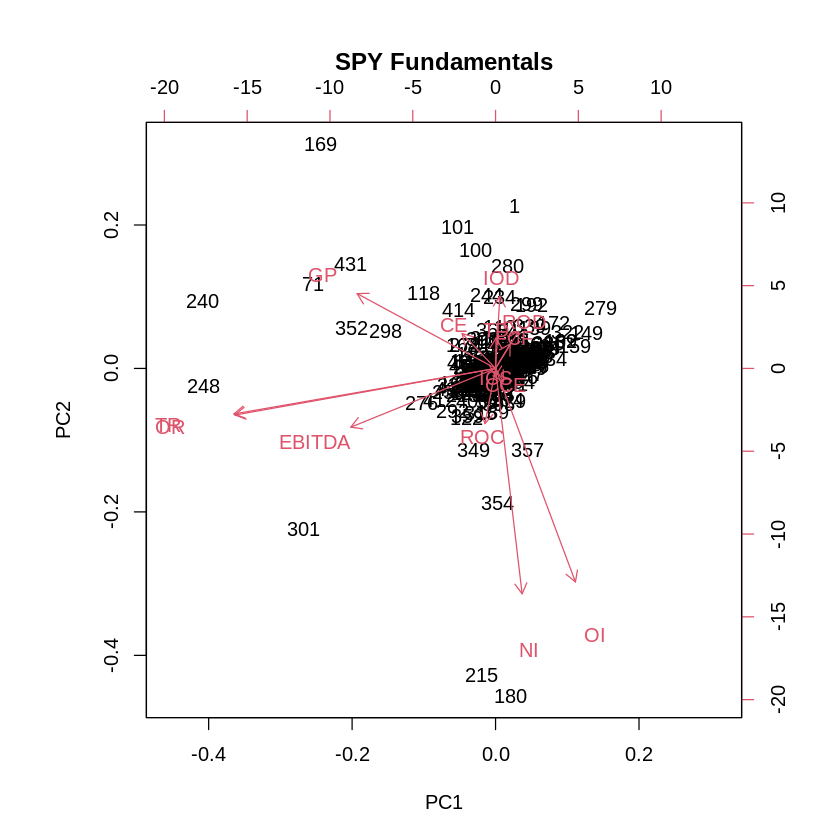

In [ ]:
stocks.pca<-prcomp(stocks.x, scale = T)
biplot(stocks.pca, main= "SPY Fundamentals")

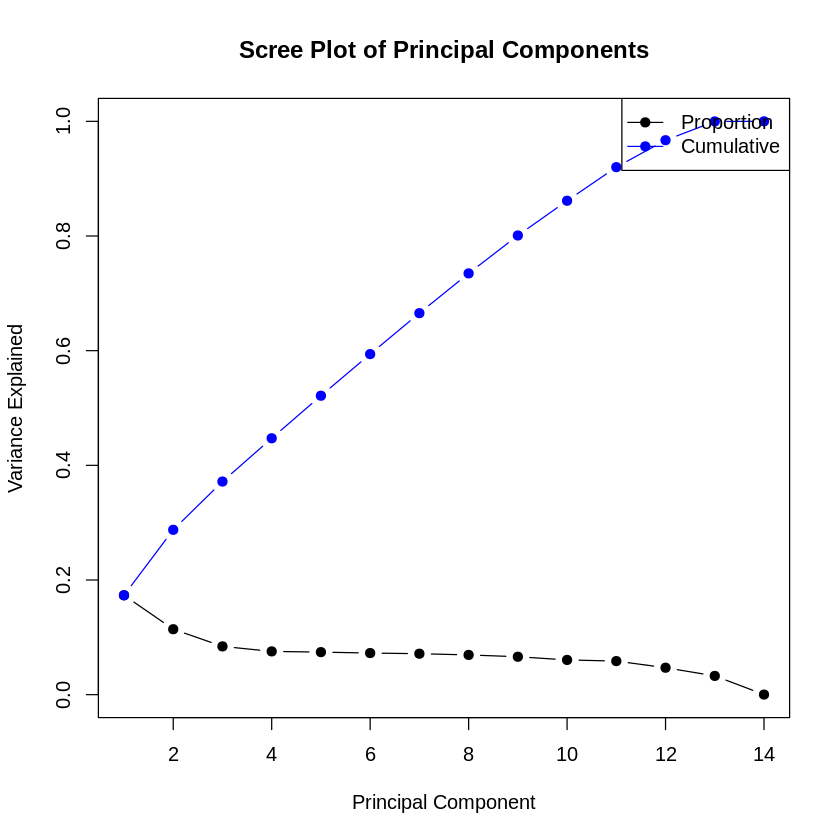

In [ ]:
# Calculate the proportion of variance explained
explained_variance <- stocks.pca$sdev^2 / sum(stocks.pca$sdev^2)

# Calculate cumulative explained variance
cumulative_variance <- cumsum(explained_variance)

# Create a scree plot with proper scaling
plot(explained_variance, type = "b", pch = 19, xlab = "Principal Component",
     ylab = "Variance Explained", ylim = c(0, 1),
     main = "Scree Plot of Principal Components", col = "black")

# Add cumulative explained variance to the same plot
lines(cumulative_variance, type = "b", pch = 19, col = "blue")

# Add legend
legend("topright", legend = c("Proportion", "Cumulative"),
       col = c("black", "blue"), lty = 1, pch = 19)



Observamos que la varianza está bastante distribuida a lo largo de las componentes principales, aunque dos destacan ligeramente más que el resto.

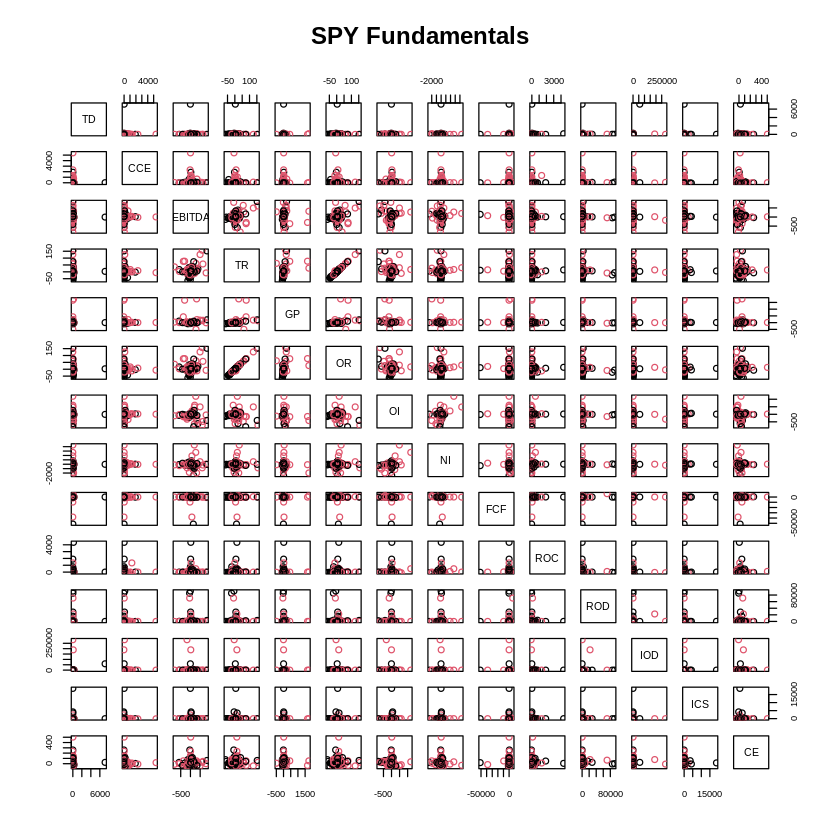

In [ ]:
plot(stocks.x, col=stocks.y, main="SPY Fundamentals", cex.axis=0.7, cex.main=1.2)

Ahora podemos observar que la separación entre las clases es casi nula, en contraste con el gráfico anterior que incluía predictores falsos.

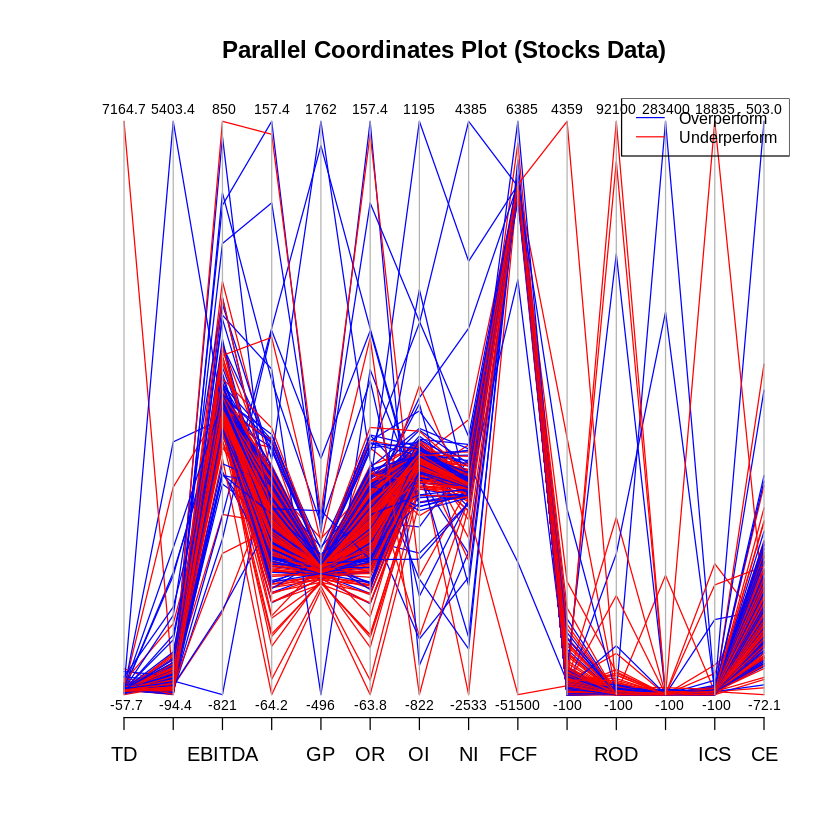

In [ ]:
# Create a color vector based on stocks.y
colors <- ifelse(stocks.y == 1, "blue", "red")  # Assuming stocks.y has values -1 and 1

# Plot parallel coordinates
parcoord(
  stocks.x,
  col = colors,
  var.label = TRUE,
  main = "Parallel Coordinates Plot (Stocks Data)"
)

# Add a legend
legend("topright", legend = c("Overperform", "Underperform"),
       col = c("blue", "red"), lty = 1, cex = 0.8)

El grafico confirma que la separación entre las clases no es muy clara en este conjunto de variables.

### Rankings

#### Forward Ranking

In [ ]:
stocks.forward.rf <- forward.ranking(stocks.x, stocks.y, "rf.est")
stocks.forward.lda <- forward.ranking(stocks.x, stocks.y, "lda.est")
stocks.forward.svm <- forward.ranking(stocks.x, stocks.y, method="svm.est")

In [ ]:
stocks.forward.rf.names <- variable_names[stocks.forward.rf]
stocks.forward.lda.names <- variable_names[stocks.forward.lda]
stocks.forward.svm.names <- variable_names[stocks.forward.svm]

cat("\n > Forward ranking RF (Variable Names) \n")
print(stocks.forward.rf.names)

cat("\n > Forward ranking LDA (Variable Names) \n")
print(stocks.forward.lda.names)

cat("\n > Forward ranking SVM (Variable Names) \n")
print(stocks.forward.svm.names)


 > Forward ranking RF (Variable Names) 
 [1] "EBITDA" "ICS"    "FCF"    "NI"     "OI"     "CCE"    "CE"     "TD"    
 [9] "GP"     "ROC"    "IOD"    "OR"     "ROD"    "TR"    

 > Forward ranking LDA (Variable Names) 
 [1] "TR"     "CCE"    "NI"     "OR"     "ROC"    "IOD"    "ICS"    "TD"    
 [9] "ROD"    "FCF"    "OI"     "CE"     "GP"     "EBITDA"

 > Forward ranking SVM (Variable Names) 
 [1] "CCE"    "EBITDA" "GP"     "TR"     "CE"     "ROD"    "TD"     "NI"    
 [9] "OR"     "OI"     "IOD"    "ROC"    "ICS"    "FCF"   


#### Backward Ranking

In [ ]:
stocks.backward.rf <- backward.ranking(stocks.x, stocks.y, "rf.est")
stocks.backward.lda <- backward.ranking(stocks.x, stocks.y, "lda.est")
stocks.backward.svm <- backward.ranking(stocks.x, stocks.y, method="svm.est")

In [ ]:
stocks.backward.rf.names <- variable_names[stocks.backward.rf]
stocks.backward.lda.names <- variable_names[stocks.backward.lda]
stocks.backward.svm.names <- variable_names[stocks.backward.svm]

cat("\n > Backward ranking RF (Variable Names) \n")
print(stocks.backward.rf.names)

cat("\n > Backward ranking LDA (Variable Names) \n")
print(stocks.backward.lda.names)

cat("\n > Backward ranking SVM (Variable Names) \n")
print(stocks.backward.svm.names)


 > Backward ranking RF (Variable Names) 
 [1] "TD"     "OI"     "CCE"    "CE"     "NI"     "FCF"    "IOD"    "ROD"   
 [9] "ICS"    "OR"     "EBITDA" "ROC"    "GP"     "TR"    

 > Backward ranking LDA (Variable Names) 
 [1] "OR"     "CCE"    "OI"     "TR"     "ROC"    "CE"     "GP"     "IOD"   
 [9] "TD"     "ROD"    "EBITDA" "ICS"    "NI"     "FCF"   

 > Backward ranking SVM (Variable Names) 
 [1] "GP"     "CCE"    "IOD"    "EBITDA" "ICS"    "OR"     "CE"     "TD"    
 [9] "OI"     "ROC"    "FCF"    "TR"     "NI"     "ROD"   


#### Kruskall Wallice Ranking

In [ ]:
stocks.kruskal <- kruskal.ranking(stocks.x, stocks.y)

In [ ]:
stocks.kruskal.names <- variable_names[stocks.kruskal]

cat("\n > Kruskal ranking \n")
print(stocks.kruskal.names)


 > Kruskal ranking 
 [1] "GP"     "TR"     "OI"     "OR"     "CCE"    "EBITDA" "NI"     "FCF"   
 [9] "ROD"    "IOD"    "ROC"    "CE"     "TD"     "ICS"   


#### RFE Ranking

In [ ]:
stocks.rfe.rf <- rfe.ranking(stocks.x, stocks.y, "imp.rf")
stocks.rfe.linsvm <- rfe.ranking(stocks.x, stocks.y, method="imp.linsvm")

In [ ]:
stocks.rfe.rf.names <- variable_names[stocks.rfe.rf]
stocks.rfe.linsvm.names <- variable_names[stocks.rfe.linsvm]

cat("\n > RFE ranking RF (Variable Names) \n")
print(stocks.rfe.rf.names)

cat("\n > RFE ranking LINSVM (Variable Names) \n")
print(stocks.rfe.linsvm.names)


 > RFE ranking RF (Variable Names) 
 [1] "OI"     "NI"     "OR"     "GP"     "EBITDA" "TR"     "CCE"    "FCF"   
 [9] "TD"     "ROD"    "IOD"    "CE"     "ROC"    "ICS"   

 > RFE ranking LINSVM (Variable Names) 
 [1] "OR"     "TR"     "GP"     "CCE"    "IOD"    "NI"     "OI"     "ROC"   
 [9] "ICS"    "CE"     "TD"     "ROD"    "FCF"    "EBITDA"


No parece haber un consenso fuerte entre los métodos sobre cuáles son las variables más importantes. Sin embargo, hay algunas que se repiten en las primeras posiciones, como Operating Income and Revenue, Gross Profit y Cash and Cash Equivalents.

Observo desde mi experiencia y me parece razonable, que lo más relevante es la capacidad de la empresa para generar dinero y mejorar sus márgenes. En contraste, factores como la generación de nueva deuda, el repago de esta o los gastos en inversiones no parecen tener una influencia significativa.

### Clustering

#### K-Means


Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 61.47 %
[1] "K-means (PCA Stocks) vs Stock Performance"
    Predicted
True   1   2
  -1 262   2
  1  166   6
[1] "----------------------------------------------------"


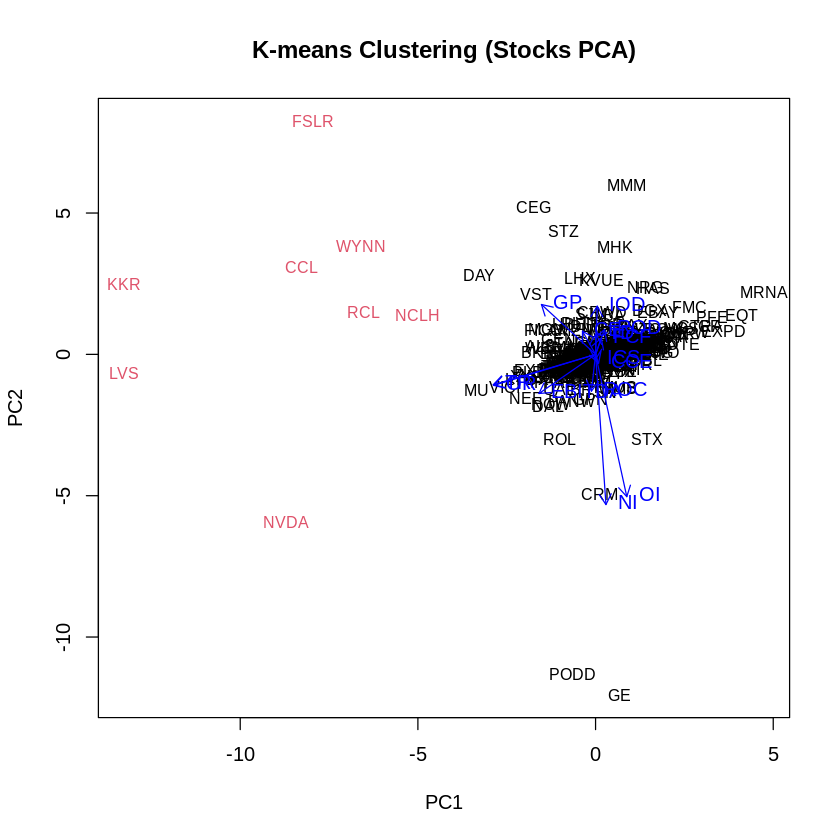

In [ ]:
kmeans <- kmeans(stocks.pca$x, centers = 2, nstart = 10)

compare_clusters(stocks.y, kmeans$cluster, "K-means (PCA Stocks) vs Stock Performance")

plot(stocks.pca$x[, 1:2], type = "n",
     xlab = "PC1", ylab = "PC2",
     main = "K-means Clustering (Stocks PCA)")

text(stocks.pca$x[, 1], stocks.pca$x[, 2],
     labels = stocks.tickers,
     col = kmeans$cluster,
     cex = 0.8)  # Adjust cex for text size if needed

arrows(0, 0, stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
       stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
       col = "blue", length = 0.1)

text(stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
     stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
     labels = rownames(stocks.pca$rotation), col = "blue", pos = 4)

#### PAM

Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 55.28 %
[1] "PAM (PCA Stocks) vs Stock Performance"
    Predicted
True   1   2
  -1 133 131
  1   64 108
[1] "----------------------------------------------------"


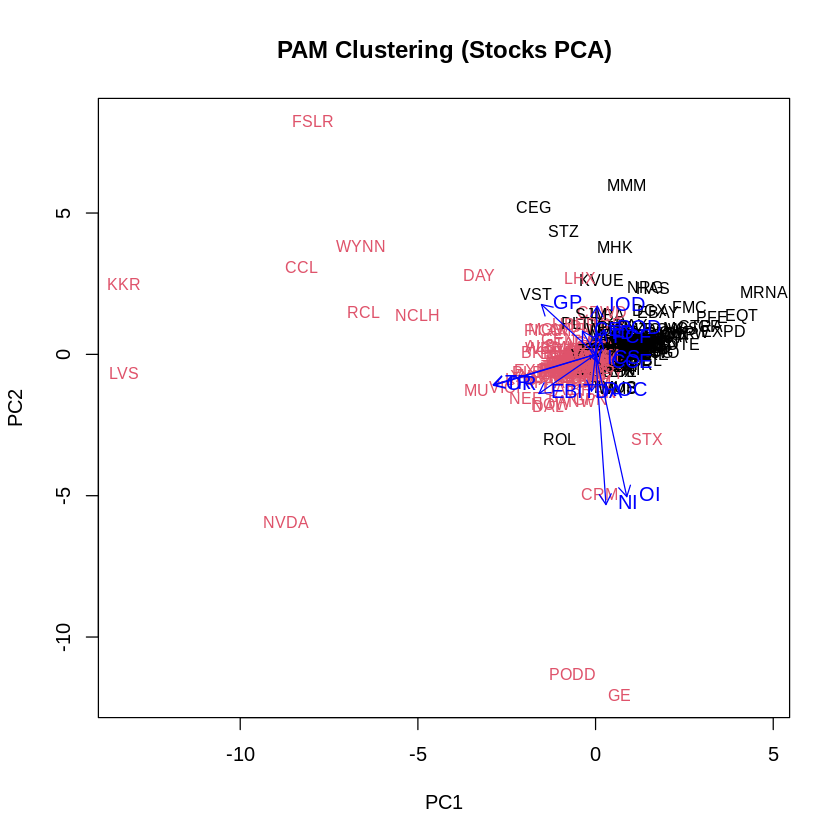

In [ ]:
pam <- pam(stocks.pca$x, k = 2, nstart = 10)

compare_clusters(stocks.y, pam$clustering, "PAM (PCA Stocks) vs Stock Performance")

plot(stocks.pca$x[, 1:2], type = "n",
     xlab = "PC1", ylab = "PC2",
     main = "PAM Clustering (Stocks PCA)")

text(stocks.pca$x[, 1], stocks.pca$x[, 2],
     labels = stocks.tickers,
     col = pam$clustering,
     cex = 0.8)  # Adjust cex for text size if needed

arrows(0, 0, stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
       stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
       col = "blue", length = 0.1)

text(stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
     stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
     labels = rownames(stocks.pca$rotation), col = "blue", pos = 4)

#### HC Average

Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 60.32 %
[1] "Hierarchical Clustering (PCA Stocks, Average) vs Stock Performance"
    Predicted
True   1   2
  -1 263   1
  1  172   0
[1] "----------------------------------------------------"


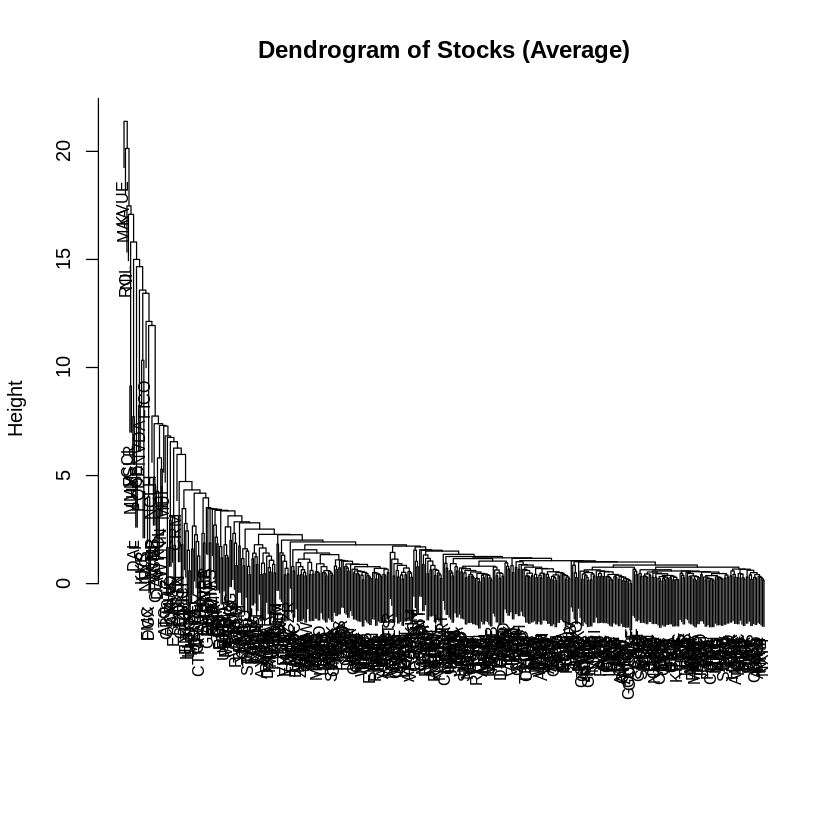

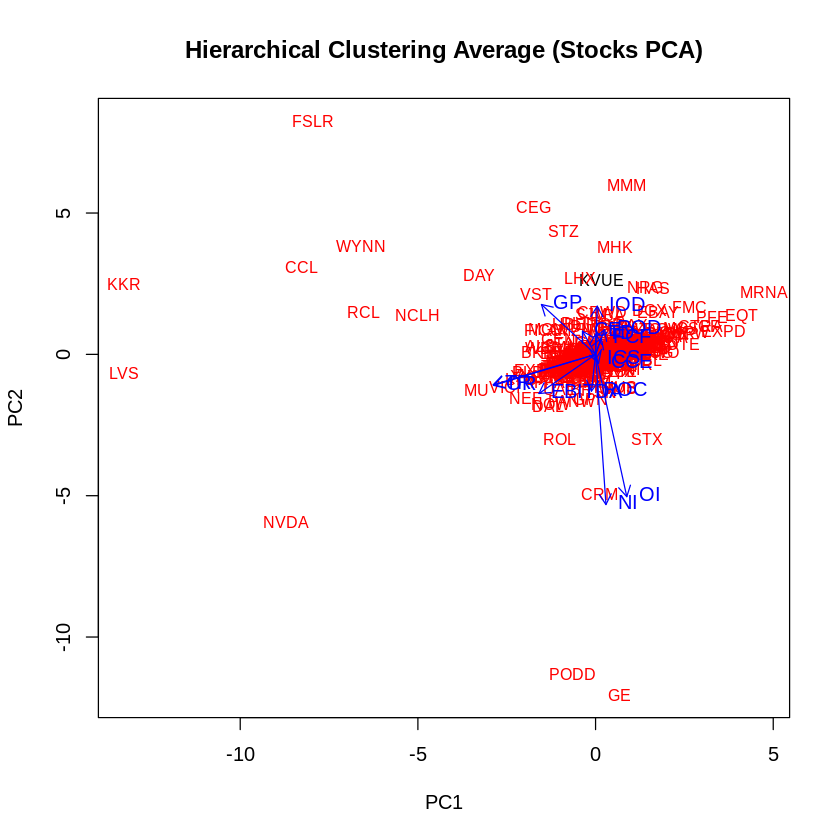

In [ ]:
hc <- hclust(dist(stocks.pca$x), method = "average")

plot(hc, labels = stocks.tickers, main = "Dendrogram of Stocks (Average)", xlab = "", sub = "", cex = 0.8)

hc_clusters <- cutree(hc, k = 2)

compare_clusters(stocks.y, hc_clusters, paste("Hierarchical Clustering (PCA Stocks, Average) vs Stock Performance"))

cluster_colors <- c("red", "black")
point_colors <- cluster_colors[hc_clusters]

plot(stocks.pca$x[, 1:2], type = "n",
     xlab = "PC1", ylab = "PC2",
     main = "Hierarchical Clustering Average (Stocks PCA)")

text(stocks.pca$x[, 1], stocks.pca$x[, 2],
     labels = stocks.tickers,
     col = point_colors,
     cex = 0.8)

arrows(0, 0, stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
       stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
       col = "blue", length = 0.1)

text(stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
     stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
     labels = rownames(stocks.pca$rotation), col = "blue", pos = 4)

#### HC Single

Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 60.32 %
[1] "Hierarchical Clustering (PCA Stocks, Single) vs Stock Performance"
    Predicted
True   1   2
  -1 263   1
  1  172   0
[1] "----------------------------------------------------"


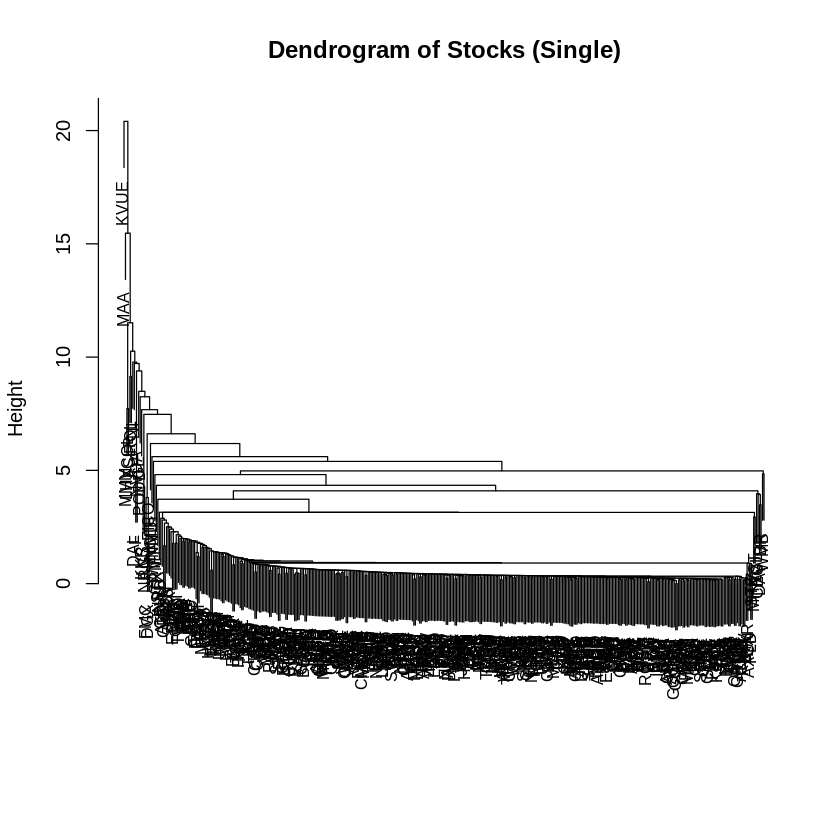

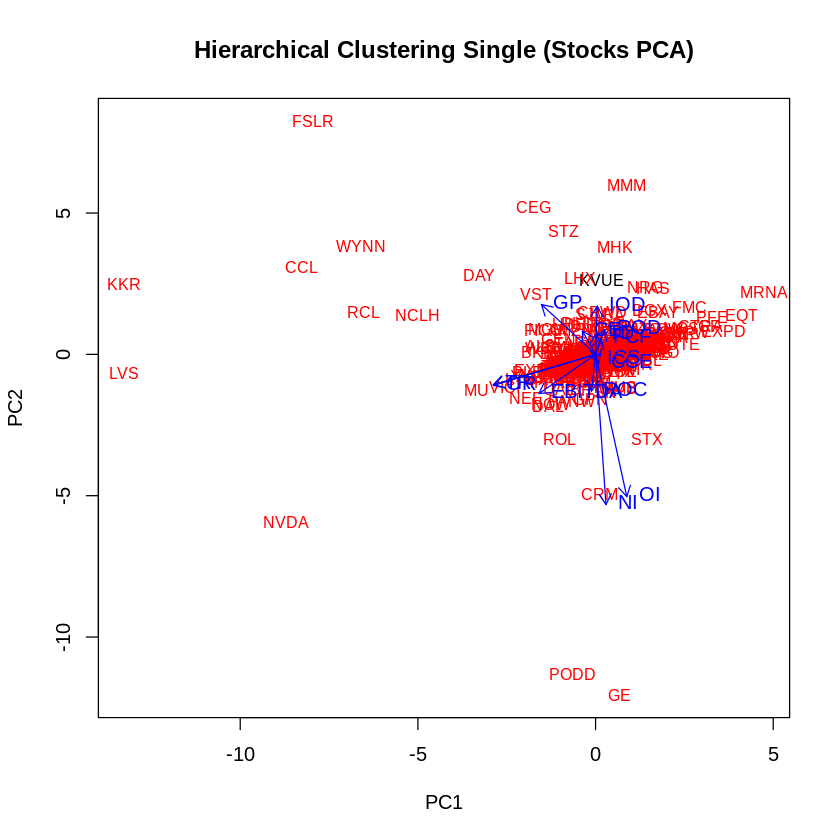

In [ ]:
hc <- hclust(dist(stocks.pca$x), method = "single")

plot(hc, labels = stocks.tickers, main = "Dendrogram of Stocks (Single)", xlab = "", sub = "", cex = 0.8)

hc_clusters <- cutree(hc, k = 2)

compare_clusters(stocks.y, hc_clusters, paste("Hierarchical Clustering (PCA Stocks, Single) vs Stock Performance"))

cluster_colors <- c("red", "black")
point_colors <- cluster_colors[hc_clusters]

plot(stocks.pca$x[, 1:2], type = "n",
     xlab = "PC1", ylab = "PC2",
     main = "Hierarchical Clustering Single (Stocks PCA)")

text(stocks.pca$x[, 1], stocks.pca$x[, 2],
     labels = stocks.tickers,
     col = point_colors,
     cex = 0.8)

arrows(0, 0, stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
       stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
       col = "blue", length = 0.1)

text(stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
     stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
     labels = rownames(stocks.pca$rotation), col = "blue", pos = 4)

#### HC Complete

Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 60.32 %
[1] "Hierarchical Clustering (PCA Stocks, Complete) vs Stock Performance"
    Predicted
True   1   2
  -1 263   1
  1  172   0
[1] "----------------------------------------------------"


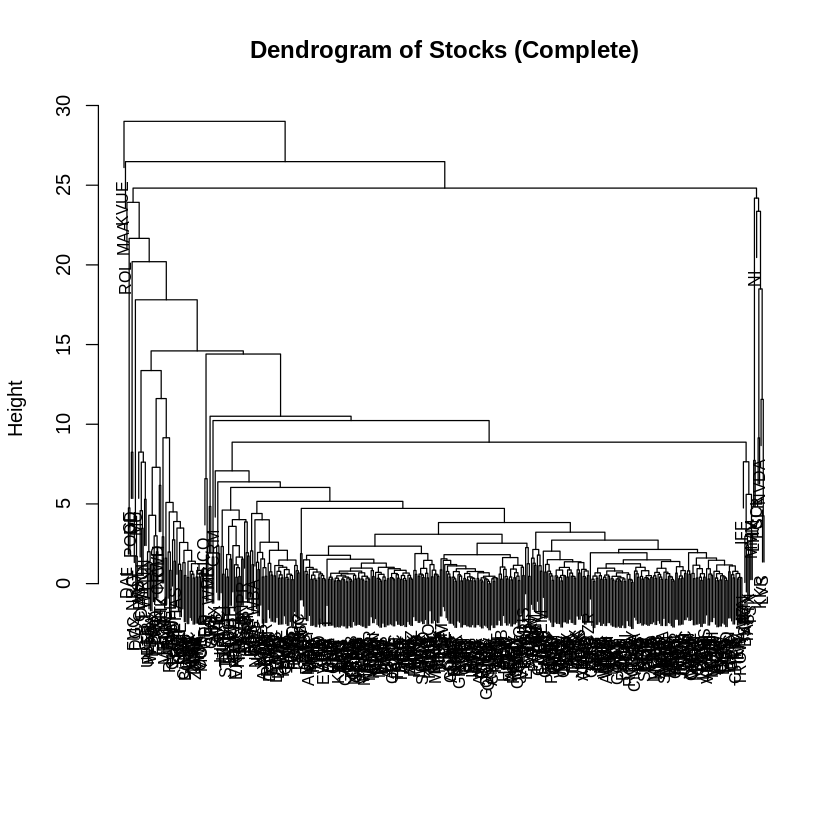

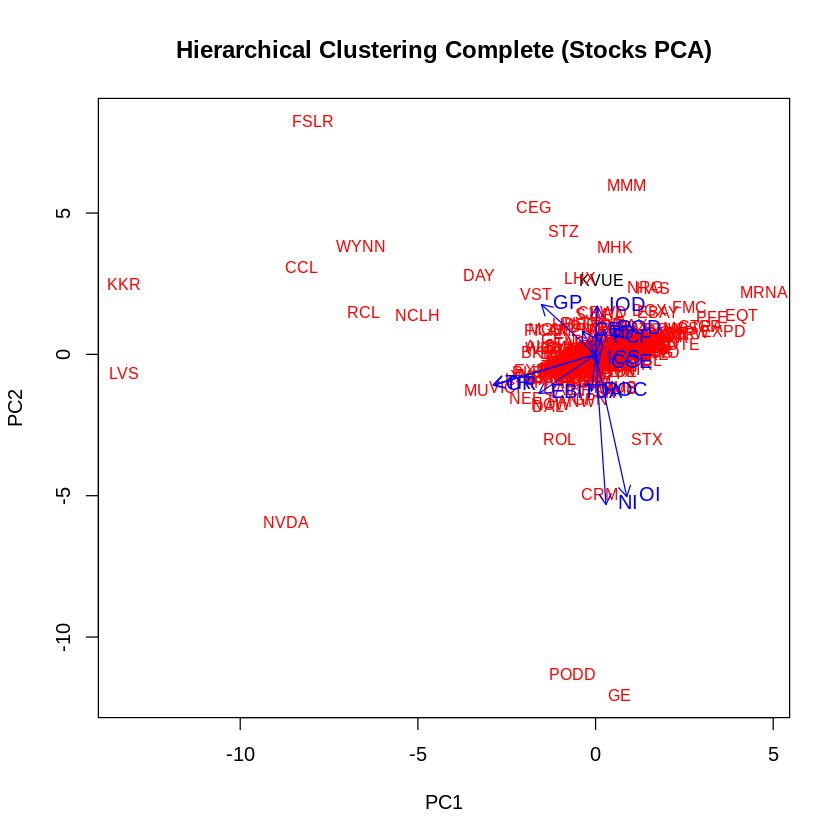

In [ ]:
hc <- hclust(dist(stocks.pca$x), method = "complete")

plot(hc, labels = stocks.tickers, main = "Dendrogram of Stocks (Complete)", xlab = "", sub = "", cex = 0.8)

hc_clusters <- cutree(hc, k = 2)

compare_clusters(stocks.y, hc_clusters, paste("Hierarchical Clustering (PCA Stocks, Complete) vs Stock Performance"))

cluster_colors <- c("red", "black")
point_colors <- cluster_colors[hc_clusters]

plot(stocks.pca$x[, 1:2], type = "n",
     xlab = "PC1", ylab = "PC2",
     main = "Hierarchical Clustering Complete (Stocks PCA)")

text(stocks.pca$x[, 1], stocks.pca$x[, 2],
     labels = stocks.tickers,
     col = point_colors,
     cex = 0.8)

arrows(0, 0, stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
       stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
       col = "blue", length = 0.1)

text(stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
     stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
     labels = rownames(stocks.pca$rotation), col = "blue", pos = 4)

Como era de esperarse, todos los métodos de clustering fallan estrepitosamente al intentar identificar las dos clases presentes en el dataset. Considerando que hay muchos datos bastante alejados de la media, este comportamiento es comprensible. Se puede observar la resistencia de PAM a los outliers, logrando clusters más balanceados, aunque sigue fallando en encontrar una clasificación correcta.

Estos métodos se aplicaron sobre una PCA (escalada) de los datos. Tal vez, con algún otro tipo de preprocesamiento, podría ser posible encontrar una estructura más clara en los datos.

### Cantidad Clusters

In [ ]:
gap <- gap_statistic(stocks.x, 15, 200)
print(paste("Clusters segun gap: ", gap))

stab <- stability_method(stocks.x, 15, 30)
print(paste("Clusters segun stability: ", which.max(stab$stability.means)))

gap <- gap_statistic(stocks.pca$x, 15, 200)
print(paste("Clusters segun gap: ", gap))

stab <- stability_method(stocks.pca$x, 15, 30)
print(paste("Clusters segun stability: ", which.max(stab$stability.means)))

[1] "Clusters segun gap:  5"
[1] "Clusters segun stability:  15"


Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”


[1] "Clusters segun gap:  8"
[1] "Clusters segun stability:  15"


Probamos gap statistic y stability para determinar la cantidad óptima de clusters, utilizando tanto los datos raw como la PCA escalada. Stability no parece encontrar una solución estable, ya que alcanza el máximo número de clusters permitido. Por otro lado, según el gap statistic, se produce un salto significativo al utilizar 5 centros sobre los datos raw. Para verificar, realizamos pruebas adicionales utilizando k-means.

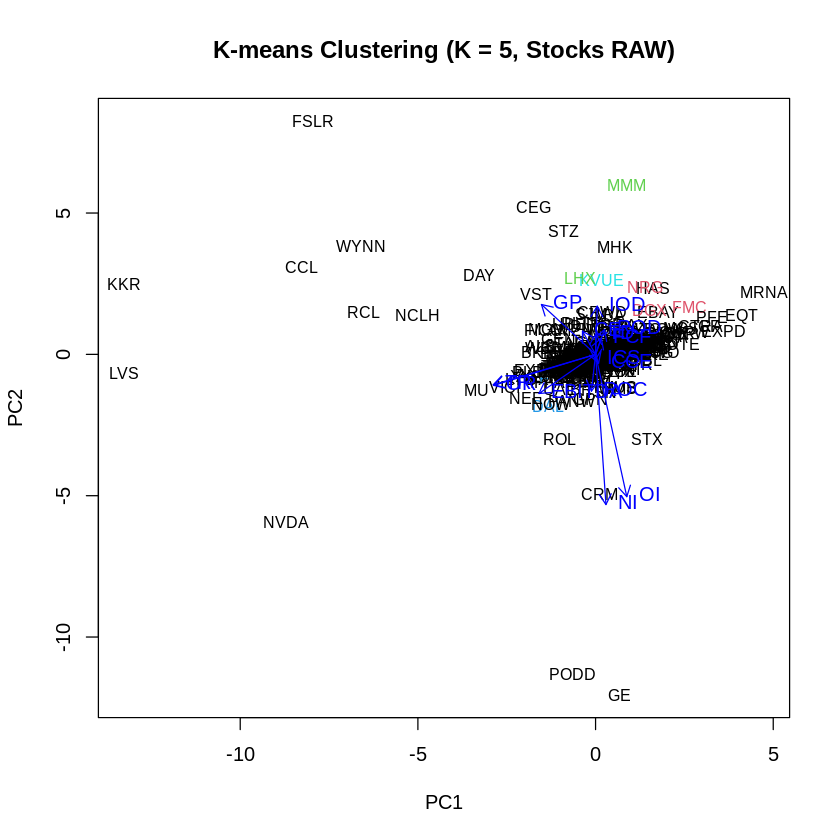

In [ ]:
kmeans <- kmeans(stocks.x, centers = 5, nstart = 10)

plot(stocks.pca$x[, 1:2], type = "n",
     xlab = "PC1", ylab = "PC2",
     main = "K-means Clustering (K = 5, Stocks RAW)")

text(stocks.pca$x[, 1], stocks.pca$x[, 2],
     labels = stocks.tickers,
     col = kmeans$cluster,
     cex = 0.8)  # Adjust cex for text size if needed

arrows(0, 0, stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
       stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
       col = "blue", length = 0.1)

text(stocks.pca$rotation[, 1] * max(stocks.pca$x[, 1]),
     stocks.pca$rotation[, 2] * max(stocks.pca$x[, 2]),
     labels = rownames(stocks.pca$rotation), col = "blue", pos = 4)

Proyectamos los resultados en la PCA para visualizarlos, pero, al observar los clusters generados y los nombres de las empresas correspondientes, no le encuentro ningún sentido.

### Clasificacion

Para la clasificación, primero dividimos los datos y reservamos un 20% para realizar la evaluacion sobre el test final. Con el 80% restante, realizamos el tuning de los parámetros para cada método, utilizando cross-validation con 5 folds, excepto en el caso de Random Forest (RF), donde aprovechamos el error OOB (Out-Of-Bag) para el ajuste de parámetros.

Para identificar los mejores parámetros, llevamos a cabo 25 iteraciones probando todas las combinaciones posibles de parámetros. En cada iteración, aumentamos en 1 el contador de la combinación de parámetros que obtuvo el menor error. Posteriormente, seleccionamos la combinación de parámetros más frecuente de estas 25 iteraciones (o la que generó el menor error en el caso de RF). Printeamos el head de esta tabla de frecuencia.

Finalmente, entrenamos el modelo utilizando los parámetros seleccionados y el 80% de los datos, para luego medir el rendimiento del modelo en el conjunto de test reservado al principio.

In [ ]:
# Split the data into 80% train and 20% test
train_indices <- createDataPartition(stocks.y, p = 0.8, list = FALSE)
train_x <- stocks.x[train_indices, ]
train_y <- stocks.y[train_indices]
test_x <- stocks.x[-train_indices, ]
test_y <- stocks.y[-train_indices]

num_iterations <- 25
num_folds <- 5

#### SVM RBF

In [ ]:
# Define the hyperparameter grid
p_grid <- expand.grid(
  gamma = 10^seq(-5, 5, length.out = 11),
  cost = 10^seq(-5, 5, length.out = 11)
)

# Frequency table for selected parameters
param_frequency <- as.data.frame(matrix(0, nrow = nrow(p_grid), ncol = 4))
colnames(param_frequency) <- c("Gamma", "Cost", "Frequency", "Mean_Error")
param_frequency$Gamma <- p_grid$gamma
param_frequency$Cost <- p_grid$cost
param_frequency$Mean_Error <- 0

for (iteration in 1:num_iterations) {

  # Create cross-validation folds
  folds <- createFolds(train_y, k = num_folds, returnTrain = TRUE)

  for (fold in 1:num_folds) {

    # Split data for this fold
    fold_train_indices <- folds[[fold]]
    fold_train_x <- train_x[fold_train_indices, ]
    fold_train_y <- train_y[fold_train_indices]
    fold_valid_x <- train_x[-fold_train_indices, ]
    fold_valid_y <- train_y[-fold_train_indices]

    # Perform grid search
    best_error <- Inf
    best_params <- NULL

    for (i in 1:nrow(p_grid)) {

      params <- p_grid[i, ]

      model <- svm(
        x = fold_train_x,
        y = fold_train_y,
        kernel = "radial",
        gamma = params$gamma,
        cost = params$cost,
        scale = TRUE
      )

      predictions <- predict(model, fold_valid_x)
      error <- mean(predictions != fold_valid_y)

      if (error < best_error) {
        best_error <- error
        best_params <- params
      }

      # Update mean error for the parameter combination
      row_index <- which(param_frequency$Gamma == params$gamma & param_frequency$Cost == params$cost)
      param_frequency$Mean_Error[row_index] <- ((param_frequency$Mean_Error[row_index] * param_frequency$Frequency[row_index]) + error) /
                                                (param_frequency$Frequency[row_index] + 1)
    }

    # Update parameter frequency
    row_index <- which(param_frequency$Gamma == best_params$gamma & param_frequency$Cost == best_params$cost)
    param_frequency$Frequency[row_index] <- param_frequency$Frequency[row_index] + 1
  }
}

# Train final model with the most frequently selected parameters
best_param_index <- which.max(param_frequency$Frequency)
final_gamma <- param_frequency$Gamma[best_param_index]
final_cost <- param_frequency$Cost[best_param_index]

final_model <- svm(
  x = train_x,
  y = train_y,
  kernel = "radial",
  gamma = final_gamma,
  cost = final_cost,
  scale = TRUE
)

# Evaluate on the test set
final_predictions <- predict(final_model, test_x)
final_error <- mean(final_predictions != test_y)

# Output results
cat("Final Error on Test Set:", final_error, "\n")
cat("Most Frequently Selected Parameters:
")
head(param_frequency[order(-param_frequency$Frequency), ])


Final Error on Test Set: 0.3139535 
Most Frequently Selected Parameters:


,Gamma,Cost,Frequency,Mean_Error
,<dbl>,<dbl>,<dbl>,<dbl>
82,0.1,100,18,0.3783528
61,1.0,1,10,0.3952857
93,0.1,1000,9,0.3968410
71,0.1,10,8,0.3779766
60,0.1,1,6,0.3819914
94,1.0,1000,6,0.4315850


#### SVM Polinomial

In [ ]:
# Define the hyperparameter grid
p_grid <- expand.grid(
  degree = 1:7,  # Polynomial degrees
  cost = 10^seq(-5, 5, length.out = 11)
)

# Frequency table for selected parameters
param_frequency <- as.data.frame(matrix(0, nrow = nrow(p_grid), ncol = 4))
colnames(param_frequency) <- c("Degree", "Cost", "Frequency", "Mean_Error")
param_frequency$Degree <- p_grid$degree
param_frequency$Cost <- p_grid$cost
param_frequency$Mean_Error <- 0

for (iteration in 1:num_iterations) {

  # Create cross-validation folds
  folds <- createFolds(train_y, k = num_folds, returnTrain = TRUE)

  for (fold in 1:num_folds) {

    # Split data for this fold
    fold_train_indices <- folds[[fold]]
    fold_train_x <- train_x[fold_train_indices, ]
    fold_train_y <- train_y[fold_train_indices]
    fold_valid_x <- train_x[-fold_train_indices, ]
    fold_valid_y <- train_y[-fold_train_indices]

    # Perform grid search
    best_error <- Inf
    best_params <- NULL

    for (i in 1:nrow(p_grid)) {

      params <- p_grid[i, ]

      model <- svm(
        x = fold_train_x,
        y = fold_train_y,
        kernel = "polynomial",
        degree = params$degree,
        cost = params$cost,
        scale = TRUE
      )

      predictions <- predict(model, fold_valid_x)
      error <- mean(predictions != fold_valid_y)

      if (error < best_error) {
        best_error <- error
        best_params <- params
      }

      # Update mean error for the parameter combination
      row_index <- which(param_frequency$Degree == params$degree & param_frequency$Cost == params$cost)
      param_frequency$Mean_Error[row_index] <- ((param_frequency$Mean_Error[row_index] * param_frequency$Frequency[row_index]) + error) /
                                                (param_frequency$Frequency[row_index] + 1)
    }

    # Update parameter frequency
    row_index <- which(param_frequency$Degree == best_params$degree & param_frequency$Cost == best_params$cost)
    param_frequency$Frequency[row_index] <- param_frequency$Frequency[row_index] + 1
  }
}

# Train final model with the most frequently selected parameters
best_param_index <- which.max(param_frequency$Frequency)
final_degree <- param_frequency$Degree[best_param_index]
final_cost <- param_frequency$Cost[best_param_index]

final_model <- svm(
  x = train_x,
  y = train_y,
  kernel = "polynomial",
  degree = final_degree,
  cost = final_cost,
  scale = TRUE
)

# Evaluate on the test set
final_predictions <- predict(final_model, test_x)
final_error <- mean(final_predictions != test_y)

# Output results
cat("Final Error on Test Set:", final_error, "\n")
cat("Most Frequently Selected Parameters:\n")
head(param_frequency[order(-param_frequency$Frequency), ])


Final Error on Test Set: 0.372093 
Most Frequently Selected Parameters:


,Degree,Cost,Frequency,Mean_Error
,<int>,<dbl>,<dbl>,<dbl>
50,1,1e+02,10,0.3739432
74,4,1e+05,9,0.4013553
52,3,1e+02,8,0.3765519
58,2,1e+03,8,0.3834266
75,5,1e+05,8,0.3889910
69,6,1e+04,6,0.3747370


#### XGBoost

In [ ]:
# Define the hyperparameter grid
p_grid <- expand.grid(
  eta = c(0.0001, 0.001, 0.005, 0.01, 0.1),  # Learning rates
  max_depth = 1:5           # Maximum depth of trees
)

# Frequency table for selected parameters
param_frequency <- as.data.frame(matrix(0, nrow = nrow(p_grid), ncol = 4))
colnames(param_frequency) <- c("Eta", "Max_Depth", "Frequency", "Mean_Error")
param_frequency$Eta <- p_grid$eta
param_frequency$Max_Depth <- p_grid$max_depth
param_frequency$Mean_Error <- 0

for (iteration in 1:num_iterations) {

  # Create cross-validation folds
  folds <- createFolds(train_y, k = num_folds, returnTrain = TRUE)

  for (fold in 1:num_folds) {

    # Split data for this fold
    fold_train_indices <- folds[[fold]]
    fold_train_x <- train_x[fold_train_indices, ]
    fold_train_y <- train_y[fold_train_indices]
    fold_valid_x <- train_x[-fold_train_indices, ]
    fold_valid_y <- train_y[-fold_train_indices]

    # Perform grid search
    best_error <- Inf
    best_params <- NULL

    for (i in 1:nrow(p_grid)) {

      params <- p_grid[i, ]

      model <- xgboost(
        data = as.matrix(fold_train_x),
        label = as.numeric(fold_train_y) - 1,  # Convert factors to 0/1
        max_depth = params$max_depth,
        eta = params$eta,
        nrounds = 1000,
        objective = "binary:logistic",
        verbose = 0
      )

      predictions <- predict(model, as.matrix(fold_valid_x))
      predictions <- ifelse(predictions > 0.5, 1, 0)
      error <- mean(predictions != (as.numeric(fold_valid_y) - 1))

      if (error < best_error) {
        best_error <- error
        best_params <- params
      }

      # Update mean error for the parameter combination
      row_index <- which(param_frequency$Eta == params$eta & param_frequency$Max_Depth == params$max_depth)
      param_frequency$Mean_Error[row_index] <- ((param_frequency$Mean_Error[row_index] * param_frequency$Frequency[row_index]) + error) /
                                                (param_frequency$Frequency[row_index] + 1)
    }

    # Update parameter frequency
    row_index <- which(param_frequency$Eta == best_params$eta & param_frequency$Max_Depth == best_params$max_depth)
    param_frequency$Frequency[row_index] <- param_frequency$Frequency[row_index] + 1
  }
}

# Train final model with the most frequently selected parameters
best_param_index <- which.max(param_frequency$Frequency)
final_eta <- param_frequency$Eta[best_param_index]
final_max_depth <- param_frequency$Max_Depth[best_param_index]

final_model <- xgboost(
  data = as.matrix(train_x),
  label = as.numeric(train_y) - 1,  # Convert factors to 0/1
  max_depth = final_max_depth,
  eta = final_eta,
  nrounds = 100,
  objective = "binary:logistic",
  verbose = 0
)

# Evaluate on the test set
final_predictions <- predict(final_model, as.matrix(test_x))
final_predictions <- ifelse(final_predictions > 0.5, 1, 0)
final_error <- mean(final_predictions != (as.numeric(test_y) - 1))

# Output results
cat("Final Error on Test Set:", final_error, "\n")
cat("Most Frequently Selected Parameters:\n")
head(param_frequency[order(-param_frequency$Frequency), ])


Final Error on Test Set: 0.372093 
Most Frequently Selected Parameters:


,Eta,Max_Depth,Frequency,Mean_Error
,<dbl>,<int>,<dbl>,<dbl>
1,1e-04,1,16,0.3729159
7,1e-03,2,15,0.3731697
4,1e-02,1,12,0.3765573
2,1e-03,1,11,0.3693304
5,1e-01,1,9,0.3789427
6,1e-04,2,7,0.3825740


#### Random Forest

In [ ]:
# Define the hyperparameter grid for mtry
mtry_values <- seq(1, ncol(stocks.x), by = 1)  # Try different values for mtry

# Frequency table for selected mtry
param_frequency <- data.frame(
  Mtry = mtry_values,
  Frequency = 0,
  Mean_OOB_Error = 0
)

for (iteration in 1:num_iterations) {

  best_oob_error <- Inf
  best_mtry <- NULL

  for (mtry in mtry_values) {

    # Train random forest model with current mtry
    rf_model <- randomForest(
      x = train_x,
      y = train_y,
      mtry = mtry,
      ntree = 1000,
      importance = FALSE,
      proximity = FALSE,
      oob.prox = FALSE
    )

    # Calculate OOB error
    oob_error <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]

    # Update mean OOB error for this mtry
    param_frequency$Mean_OOB_Error[param_frequency$Mtry == mtry] <-
      ((param_frequency$Mean_OOB_Error[param_frequency$Mtry == mtry] * param_frequency$Frequency[param_frequency$Mtry == mtry]) + oob_error) /
      (param_frequency$Frequency[param_frequency$Mtry == mtry] + 1)

    # Increment frequency
    param_frequency$Frequency[param_frequency$Mtry == mtry] <- param_frequency$Frequency[param_frequency$Mtry == mtry] + 1

    # Update best parameters
    if (oob_error < best_oob_error) {
      best_oob_error <- oob_error
      best_mtry <- mtry
    }
  }
}

# Train final model with the best mtry
final_mtry <- param_frequency$Mtry[which.min(param_frequency$Mean_OOB_Error)]
final_rf_model <- randomForest(
  x = train_x,
  y = train_y,
  mtry = final_mtry,
  ntree = 1000
)

# Evaluate on the test set
test_predictions <- predict(final_rf_model, newdata = test_x)
test_error <- mean(test_predictions != test_y)

# Output results
cat("Final Error on Test Set:", test_error, "\n")
cat("Most Frequently Selected Mtry Values:\n")
param_frequency <- param_frequency[order(param_frequency$Mean_OOB_Error), ]
print(param_frequency)


Final Error on Test Set: 0.3837209 
Most Frequently Selected Mtry Values:
   Mtry Frequency Mean_OOB_Error
1     1        25      0.3484571
2     2        25      0.3488000
3     3        25      0.3582857
4     4        25      0.3619429
5     5        25      0.3658286
6     6        25      0.3728000
7     7        25      0.3760000
8     8        25      0.3803429
9     9        25      0.3812571
10   10        25      0.3824000
12   12        25      0.3838857
11   11        25      0.3862857
13   13        25      0.3872000
14   14        25      0.3877714


Primero que todo, los resultados arrojan mejores numeros de lo que esperaba, indicando que sí existe algún tipo de correlación. Esto refuerza la teoría de los mercados eficientes, y que, a pesar del ruido geopolítico o los riesgos específicos de una empresa en particular, a gran escala, los balances financieros generales son un indicador significativo y no despreciable. Además, cualquier posible ventaja de información en el mercado, por más mínima que sea, sugiere la existencia de oportunidades de arbitraje.

Un aspecto que llamó particularmente mi atención fue la discrepancia entre los resultados de SVM con kernel RBF y los demás métodos, que obtuvieron resultados más similares entre sí. Esto podría sugerir que los datos son más separables mediante una hiperesfera, aunque también es posible que esta discrepancia se deba a que la distribución de los datos de prueba fue particularmente favorable para este método. Esto último se evidencia en que, durante la validación cruzada, los resultados de SVM RBF fueron más parecidos a los obtenidos por los otros métodos.

## Comparacion con SPY 2022Q3-2023Q3

BONUS TRACK! Queria ver los resultados obtenidos se mantenían consistentes al extrapolarlos a otro periodo de tiempo. Sin embargo, un posible inconveniente podría ser la influencia de factores geopolíticos, ya que estos dos periodos podrían no ser directamente comparables.
Para esto, genero el mismo dataset pero comparando los periodos fiscales de 2022Q3 a 2023Q3

### Cleaning

In [ ]:
stocksCSV2 <- read.csv('/content/spyFundamentals2022_2023.csv')
summary(stocksCSV2)

    Ticker          Market.Capitalization   Total.Debt      
 Length:502         Min.   :-58.045       Min.   :-100.000  
 Class :character   1st Qu.: -3.483       1st Qu.:  -4.832  
 Mode  :character   Median : 11.381       Median :   0.181  
                    Mean   : 16.478       Mean   :  28.075  
                    3rd Qu.: 29.607       3rd Qu.:  11.029  
                    Max.   :378.322       Max.   :3480.165  
                    NA's   :10            NA's   :7         
 Cash.and.Cash.Equivalents Enterprise.Value       EBITDA         
 Min.   : -98.258          Min.   :-302.706   Min.   :-2298.333  
 1st Qu.: -29.801          1st Qu.:  -1.843   1st Qu.:   -9.681  
 Median :  -3.027          Median :  10.720   Median :    6.329  
 Mean   :   9.655          Mean   :  16.648   Mean   :   17.873  
 3rd Qu.:  23.474          3rd Qu.:  26.557   3rd Qu.:   22.931  
 Max.   :1179.928          Max.   :1055.583   Max.   : 2516.364  
 NA's   :5                 NA's   :12         NA's

Procedemos a limpiar el dataset de igual manera

In [ ]:
stocksCSV2_clean <- subset(stocksCSV2,
                          !is.na(Gross.Profit) &
                          !is.na(Stock.Price.Change) &
                          !is.na(Enterprise.Value) &
                          !is.na(Market.Capitalization))
stocksCSV2_clean[is.na(stocksCSV2_clean)] <- 0
summary(stocksCSV2_clean)

    Ticker          Market.Capitalization   Total.Debt      
 Length:438         Min.   :-58.045       Min.   : -57.726  
 Class :character   1st Qu.: -3.172       1st Qu.:  -5.098  
 Mode  :character   Median : 12.299       Median :   0.081  
                    Mean   : 17.654       Mean   :  17.680  
                    3rd Qu.: 30.345       3rd Qu.:  10.600  
                    Max.   :378.322       Max.   :3379.012  
 Cash.and.Cash.Equivalents Enterprise.Value      EBITDA         
 Min.   : -98.258          Min.   :-54.856   Min.   :-2298.333  
 1st Qu.: -31.853          1st Qu.: -1.391   1st Qu.:   -9.550  
 Median :  -4.530          Median : 12.065   Median :    6.708  
 Mean   :   9.617          Mean   : 16.390   Mean   :   18.669  
 3rd Qu.:  23.908          3rd Qu.: 26.730   3rd Qu.:   23.060  
 Max.   :1179.928          Max.   :330.233   Max.   : 2516.364  
 Total.Revenue      Gross.Profit       Operating.Revenue Operating.Income  
 Min.   :-65.447   Min.   :-284.2585   Min

In [ ]:
start_date <- "2022-10-31"
end_date <- "2023-10-31"

spy_data <- tq_get("^GSPC", from = start_date, to = end_date)

spy_total_return2 <- ((last(spy_data$adjusted, na.rm = TRUE) / first(spy_data$adjusted, na.rm = TRUE)) - 1) * 100
cat("Total Return between", start_date, "and", end_date, "is:", round(spy_total_return2, 2), "%\n")

Total Return between 2022-10-31 and 2023-10-31 is: 7.61 %


No hubo tanta suerte como el otro periodo jij

In [ ]:
stocksCSV2_clean$Stock.Price.Change <- ifelse(
  stocksCSV2_clean$Stock.Price.Change > spy_total_return2,  # Compare with index return
  1,  # Overperforms
  -1  # Underperforms
)

stocksCSV2_clean$Stock.Price.Change <- as.factor(stocksCSV2_clean$Stock.Price.Change)
summary(stocksCSV2_clean)

    Ticker          Market.Capitalization   Total.Debt      
 Length:438         Min.   :-58.045       Min.   : -57.726  
 Class :character   1st Qu.: -3.172       1st Qu.:  -5.098  
 Mode  :character   Median : 12.299       Median :   0.081  
                    Mean   : 17.654       Mean   :  17.680  
                    3rd Qu.: 30.345       3rd Qu.:  10.600  
                    Max.   :378.322       Max.   :3379.012  
 Cash.and.Cash.Equivalents Enterprise.Value      EBITDA         
 Min.   : -98.258          Min.   :-54.856   Min.   :-2298.333  
 1st Qu.: -31.853          1st Qu.: -1.391   1st Qu.:   -9.550  
 Median :  -4.530          Median : 12.065   Median :    6.708  
 Mean   :   9.617          Mean   : 16.390   Mean   :   18.669  
 3rd Qu.:  23.908          3rd Qu.: 26.730   3rd Qu.:   23.060  
 Max.   :1179.928          Max.   :330.233   Max.   : 2516.364  
 Total.Revenue      Gross.Profit       Operating.Revenue Operating.Income  
 Min.   :-65.447   Min.   :-284.2585   Min

In [ ]:
stocks2.tickers <- stocksCSV2_clean$Ticker
stocks2.x <- stocksCSV2_clean[, !(colnames(stocksCSV2_clean) %in% c("Stock.Price.Change", "Ticker", "Market.Capitalization", "Enterprise.Value"))]
stocks2.y <- stocksCSV2_clean$Stock.Price.Change
colnames(stocks2.x) <- c("TD", "CCE", "EBITDA",
                        "TR", "GP", "OR", "OI", "NI",
                        "FCF", "ROC", "ROD", "IOD", "ICS", "CE")
variable_names <- colnames(stocks2.x)

rownames(stocks2.x) <- NULL
rownames(stocks2.y) <- NULL
rownames(stocks2.tickers) <- NULL

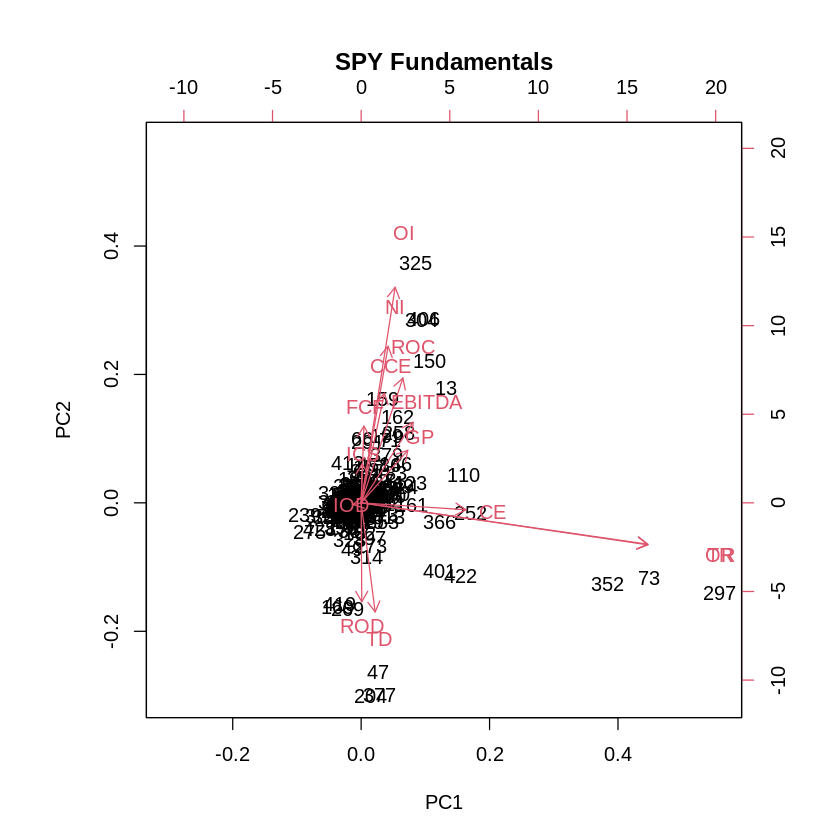

In [ ]:
stocks2.pca<-prcomp(stocks2.x, scale = T)
biplot(stocks2.pca, main= "SPY Fundamentals")

Me pareció que ese grupo de 3 estaba demasiado alejado del resto, por lo que decidí considerarlos como outliers y eliminarlos del análisis.

In [ ]:
stocks2.x <- stocks2.x[-c(297,73,352), ]
stocks2.y <- stocks2.y[-c(297,73,352)]
stocks2.tickers <- stocks2.tickers[-c(297,73,352)]

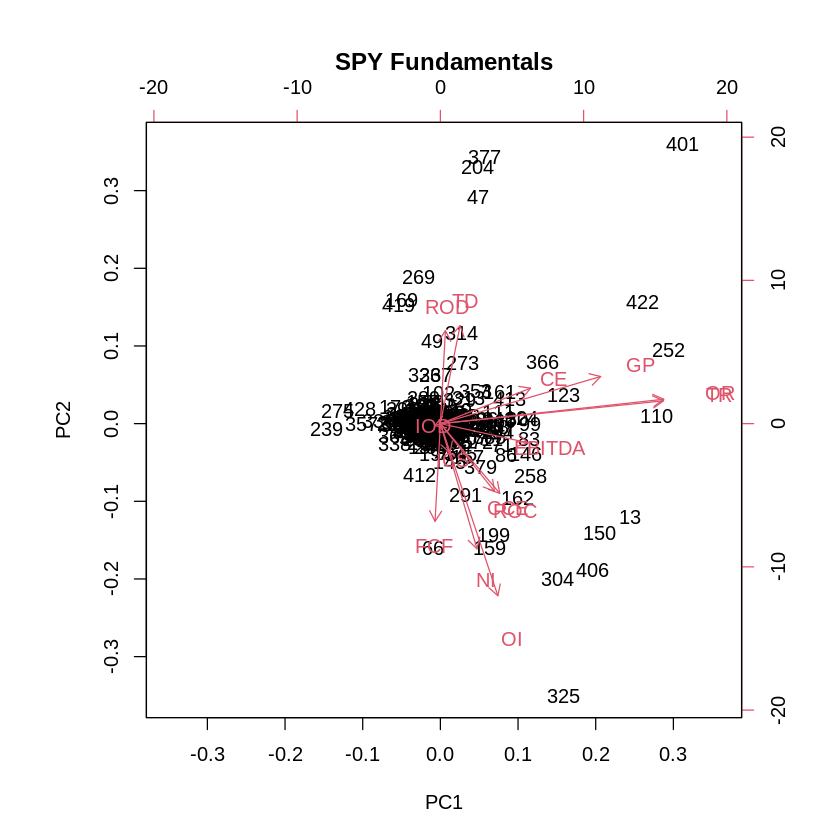

In [ ]:
stocks2.pca<-prcomp(stocks2.x, scale = T)
biplot(stocks2.pca, main= "SPY Fundamentals")

### Clasificacion

Ahora, en lugar de reservar un 20% de los datos para pruebas, utilizamos el conjunto correspondiente al nuevo período como test. Aplicamos los mejores parámetros seleccionados en los métodos anteriores, salvo en RF que corre rapidito.

In [ ]:
# Define the hyperparameter grid for mtry
mtry_values <- seq(1, ncol(stocks.x), by = 1)  # Try different values for mtry

# Frequency table for selected mtry
param_frequency <- data.frame(
  Mtry = mtry_values,
  Frequency = 0,
  Mean_OOB_Error = 0
)

for (iteration in 1:num_iterations) {

  best_oob_error <- Inf
  best_mtry <- NULL

  for (mtry in mtry_values) {

    # Train random forest model with current mtry
    rf_model <- randomForest(
      x = stocks.x,
      y = stocks.y,
      mtry = mtry,
      ntree = 1000,
      importance = FALSE,
      proximity = FALSE,
      oob.prox = FALSE
    )

    # Calculate OOB error
    oob_error <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]

    # Update mean OOB error for this mtry
    param_frequency$Mean_OOB_Error[param_frequency$Mtry == mtry] <-
      ((param_frequency$Mean_OOB_Error[param_frequency$Mtry == mtry] * param_frequency$Frequency[param_frequency$Mtry == mtry]) + oob_error) /
      (param_frequency$Frequency[param_frequency$Mtry == mtry] + 1)

    # Increment frequency
    param_frequency$Frequency[param_frequency$Mtry == mtry] <- param_frequency$Frequency[param_frequency$Mtry == mtry] + 1

    # Update best parameters
    if (oob_error < best_oob_error) {
      best_oob_error <- oob_error
      best_mtry <- mtry
    }
  }
}

# Train final model with the best mtry
final_mtry <- param_frequency$Mtry[which.min(param_frequency$Mean_OOB_Error)]
final_rf_model <- randomForest(
  x = stocks.x,
  y = stocks.y,
  mtry = final_mtry,
  ntree = 1000
)

# Evaluate on the test set
test_predictions <- predict(final_rf_model, newdata = stocks2.x)
test_error <- mean(test_predictions != stocks2.y)

# Output results
cat("Final Error on Test Set:", test_error, "\n")
cat("Most Frequently Selected Mtry Values:\n")
param_frequency <- param_frequency[order(param_frequency$Mean_OOB_Error), ]
print(param_frequency)


Final Error on Test Set: 0.4344828 
Most Frequently Selected Mtry Values:
   Mtry Frequency Mean_OOB_Error
2     2        25      0.3581651
3     3        25      0.3612844
1     1        25      0.3615596
5     5        25      0.3658716
10   10        25      0.3668807
4     4        25      0.3679817
14   14        25      0.3681651
11   11        25      0.3686239
12   12        25      0.3687156
9     9        25      0.3691743
6     6        25      0.3694495
13   13        25      0.3702752
7     7        25      0.3709174
8     8        25      0.3711927


In [ ]:
final_gamma <- 0.1
final_cost <- 100

final_model <- svm(
  x = stocks.x,
  y = stocks.y,
  kernel = "radial",
  gamma = final_gamma,
  cost = final_cost,
  scale = TRUE
)

# Evaluate on the test set
final_predictions <- predict(final_model, stocks2.x)
final_error <- mean(final_predictions != stocks2.y)

# Output results
cat("Final Error on Test Set:", final_error, "\n")


Final Error on Test Set: 0.3862069 


In [ ]:
final_eta <- 1e-04
final_max_depth <- 1

final_model <- xgboost(
  data = as.matrix(stocks.x),
  label = as.numeric(stocks.y) - 1,  # Convert factors to 0/1
  max_depth = final_max_depth,
  eta = final_eta,
  nrounds = 100,
  objective = "binary:logistic",
  verbose = 0
)

# Evaluate on the test set
final_predictions <- predict(final_model, as.matrix(stocks2.x))
final_predictions <- ifelse(final_predictions > 0.5, 1, 0)
final_error <- mean(final_predictions != (as.numeric(stocks2.y) - 1))

# Output results
cat("Final Error on Test Set:", final_error, "\n")

Final Error on Test Set: 0.445977 


In [ ]:
final_eta <- 1e-03
final_max_depth <- 2

final_model <- xgboost(
  data = as.matrix(stocks.x),
  label = as.numeric(stocks.y) - 1,  # Convert factors to 0/1
  max_depth = final_max_depth,
  eta = final_eta,
  nrounds = 100,
  objective = "binary:logistic",
  verbose = 0
)

# Evaluate on the test set
final_predictions <- predict(final_model, as.matrix(stocks2.x))
final_predictions <- ifelse(final_predictions > 0.5, 1, 0)
final_error <- mean(final_predictions != (as.numeric(stocks2.y) - 1))

# Output results
cat("Final Error on Test Set:", final_error, "\n")

Final Error on Test Set: 0.4413793 


Nuevamente, SVM con kernel RBF destaca sobre los otros métodos, logrando un muy buen desempeño, incluso considerando que los diferentes períodos analizados podrían introducir un mayor ruido debido a factores externos.